In [1]:
libraries = c("dplyr","magrittr","tidyr","ggplot2","readxl","nimble","HDInterval","glue","lhs",
              "gridExtra","zoo","RColorBrewer","coda","grid","scales","foreach","doParallel","doRNG")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE) }

# to show the plots as svg-graphics in Jupyter
options(jupyter.plot_mimetypes = "image/png") 

if (Sys.info()[['sysname']]=='Windows') {
    windowsFonts(Times = windowsFont("Times New Roman"))
    theme_set(theme_bw(base_size=11,base_family='Times')) 
} else { theme_set(theme_bw(base_size=11)) }

clrs = c("#1b9e77","#d95f02","#7570b3")

'%&%' = function(x,y)paste0(x,y)

rho = 0.19

nimble version 0.6-12 is loaded.
For more information on NIMBLE and a User Manual,
please visit http://R-nimble.org.
Loading required package: iterators
Loading required package: parallel
Loading required package: rngtools
Loading required package: pkgmaker
Loading required package: registry

Attaching package: 'pkgmaker'

The following object is masked from 'package:nimble':

    getLoadingNamespace

The following object is masked from 'package:base':

    isFALSE



# Incubation time + Time from exposure to death

Data is taken from the Carey et al (1972) Lassa fever: epidemiological aspects of the 1970 epidemic, Jos, Nigeria.

<img src="../data/Lassa1970.png" style="width: 75%;"/>

The digitized data is shown below

<img src="../data/Lassa1970_reconstructed.png" style="width: 75%;"/>

In [2]:
## Data
#### excluding index case
onsetTimes = c(17, 19, 21, 21, 21, 22, 22, 23, 23, 23, 23, 23, 25, 26, 26, 26, 27, 31, 39, 41, 41, 42, 44)
deathTimes = c(33, 48, 31, 47, 30, 41, 37, 32, 31, 35, 54, 30, 31, 33, 30, 33, 48, 39, 51, 48, 55, 60, 62)
## Prior knowledge
exposureTimesLower = c(5,  9,  5,  9,  5,  5,  5,  11, 5,  5,  13, 11, 12, 5,  11, 11, 5,  5,  12, 25, 5,  25, 25)
exposureTimesUpper = c(15, 18, 18, 15, 18, 18, 18, 15, 18, 18, 14, 15, 18, 18, 15, 15, 18, 18, 18, 31, 18, 31, 31)

The listed numbers above fit the figure from Jos study in the following manner:

<img src="../data/Lassa1970_adjustment.png" style="width: 75%;"/>

Here, the grey areas indicate probable period of exposure, dark yellow areas indicate the time period from illness onset to death.

**Some remarks:**
* Index case was omitted
* Case #2: Grey area differs from the arrow lines, because the dates indicated after in the description of the case are different from the arrow lines. So we followed the discription of the case rather than arrow lines
* Case #12: due to unknown length of expose, we admit it to one day
* Case #22: the case suffered extra-hospital transmission due to exposure to the case #14. Therefore we assign the exposure period to the time period from illness onset to death of the case #14. The same was done to two other cases #23 and #24
* Cases #6, #18, and #19: since the period of exposure was not determined and it is known that the transmission occurred through exposure to the index case, we assigned the period of exposure to the time period from illness onset to death of the index case

## Using Bayesian

In [3]:
## Initialization
nimIncubationData = list(
    onsetTime = onsetTimes,
    deathTime = deathTimes,
    exposureTimeLower = exposureTimesLower, 
    exposureTimeUpper = exposureTimesUpper
)
nimIncubationConsts = list(
    nCases = length(onsetTimes),
    incubation_uncertainty = 0.5,
    death_uncertainty = 0.5
)
nimIncubationInits = list(
    incubation_mean = mean(onsetTimes-.5*(exposureTimesLower+exposureTimesUpper)), 
    incubation_sd = sqrt(var(onsetTimes-.5*(exposureTimesLower+exposureTimesUpper))),
    death_mean = mean(deathTimes-onsetTimes),
    death_sd = sqrt(var(deathTimes-onsetTimes)),
    exposureTime = .5*(exposureTimesLower+exposureTimesUpper),
    exposure_mu = .5*(exposureTimesLower+exposureTimesUpper),
    exposure_sigma = (exposureTimesUpper-exposureTimesLower)/1.96/2,
    incubationTime = onsetTimes-.5*(exposureTimesLower+exposureTimesUpper),
    timeToDeath = deathTimes-onsetTimes
)
## Main script
nimIncubationCode = nimbleCode({
    # priors for parameters of incubation period
    incubation_mean ~ dinvgamma(0.001, 0.001)
    incubation_sd ~ dinvgamma(0.001, 0.001) 
    death_mean ~ dinvgamma(0.001, 0.001)
    death_sd ~ dinvgamma(0.001, 0.001)
    # priors for known time of exposure
    exposure_mu[1:nCases] <- (exposureTimeLower[1:nCases]+exposureTimeUpper[1:nCases])/2
    exposure_sigma[1:nCases] <- (exposureTimeUpper[1:nCases]-exposureTimeLower[1:nCases])/1.96/2
    for (k in 1:nCases) {
        exposureTime[k] ~ dnorm(exposure_mu[k], sd=exposure_sigma[k])
        incubationTime[k] ~ dgamma(mean=incubation_mean, sd=incubation_sd)
        timeToDeath[k] ~ dgamma(mean=death_mean, sd=death_sd)
        onsetTime[k] ~ dnorm(exposureTime[k] + incubationTime[k], sd=incubation_uncertainty)
        deathTime[k] ~ dnorm(exposureTime[k] + incubationTime[k] + timeToDeath[k], sd=death_uncertainty)
    }
})
## Nimble Model
nimIncubationModel = nimbleModel(nimIncubationCode,
                        data = nimIncubationData,
                        constants = nimIncubationConsts,
                        inits = nimIncubationInits)
nimIncubationConf = configureMCMC(nimIncubationModel,print=FALSE)

adpInterval = 100
nimIncubationConf$addSampler(target = c("incubation_mean","incubation_sd","death_mean","death_sd"), 
                             type = "RW_block", control = list(adaptInterval = adpInterval))

defining model...
building model...
setting data and initial values...
running calculate on model (any error reports that follow may simply reflect missing values in model variables) ... 
checking model sizes and dimensions...
model building finished.
Note: Assigning an RW_block sampler to nodes with very different scales can result in low MCMC efficiency.  If all nodes assigned to RW_block are not on a similar scale, we recommend providing an informed value for the "propCov" control list argument, or using the AFSS sampler instead.


In [4]:
## Checking that all variables are properly initialized
nimIncubationModel$initializeInfo()

All model variables are initialized.


## First run of MCMC simulations with thinning parameter equal one

In [5]:
## Model compilation
nimIncubationMCMC = buildMCMC(nimIncubationConf)
compiledIncubationModel = compileNimble(nimIncubationModel,nimIncubationMCMC)

compiling... this may take a minute. Use 'showCompilerOutput = TRUE' to see C++ compiler details.
compilation finished.


In [6]:
set.seed(0) #for reproducibility
Niter = 1e4
compiledIncubationModel$nimIncubationMCMC$run(niter=Niter)
# runMCMC(compiledIncubationModel$nimIncubationMCMC,niter=Niter,nchains=3)
compiledIncubationModel$nimIncubationMCMC$mvSamples %>% as.matrix %>% as.data.frame -> nimIncubationSamples

## Credible intervals
IncubationCIs = hdi(nimIncubationSamples,.95) %>% as.data.frame %>% { tibble::rownames_to_column(.,"var") }

nimIncubationSamples %>% 
    summarise_all(funs(mean)) %>%
    mutate(var="median") %>% 
    rbind(IncubationCIs) %>% 
    select(var,everything()) -> IncubationCIs

IncubationCIs 

|-------------|-------------|-------------|-------------|
|-------------------------------------------------------|


NULL

var,death_mean,death_sd,exposureTime[1],exposureTime[2],exposureTime[3],exposureTime[4],exposureTime[5],exposureTime[6],exposureTime[7],...,exposureTime[16],exposureTime[17],exposureTime[18],exposureTime[19],exposureTime[20],exposureTime[21],exposureTime[22],exposureTime[23],incubation_mean,incubation_sd
median,13.80314,7.601208,9.258563,11.874476,10.330390,11.584948,10.317724,10.729090,10.861331,...,13.09523,12.975296,12.67277,15.49160,28.16833,13.380108,28.33196,28.57128,12.94361,4.853919
lower,10.65016,4.860420,5.477912,8.185369,5.550139,8.589201,5.450397,6.232228,6.192414,...,11.12846,7.246828,7.22469,12.49087,25.34902,6.331282,25.39477,25.62248,10.69782,3.000283
upper,17.10592,10.523737,13.433105,15.843922,14.932433,14.430637,15.434024,15.504876,15.476841,...,15.03916,17.994876,18.58045,18.45181,30.95909,19.037370,31.59752,31.89237,14.97186,6.957544


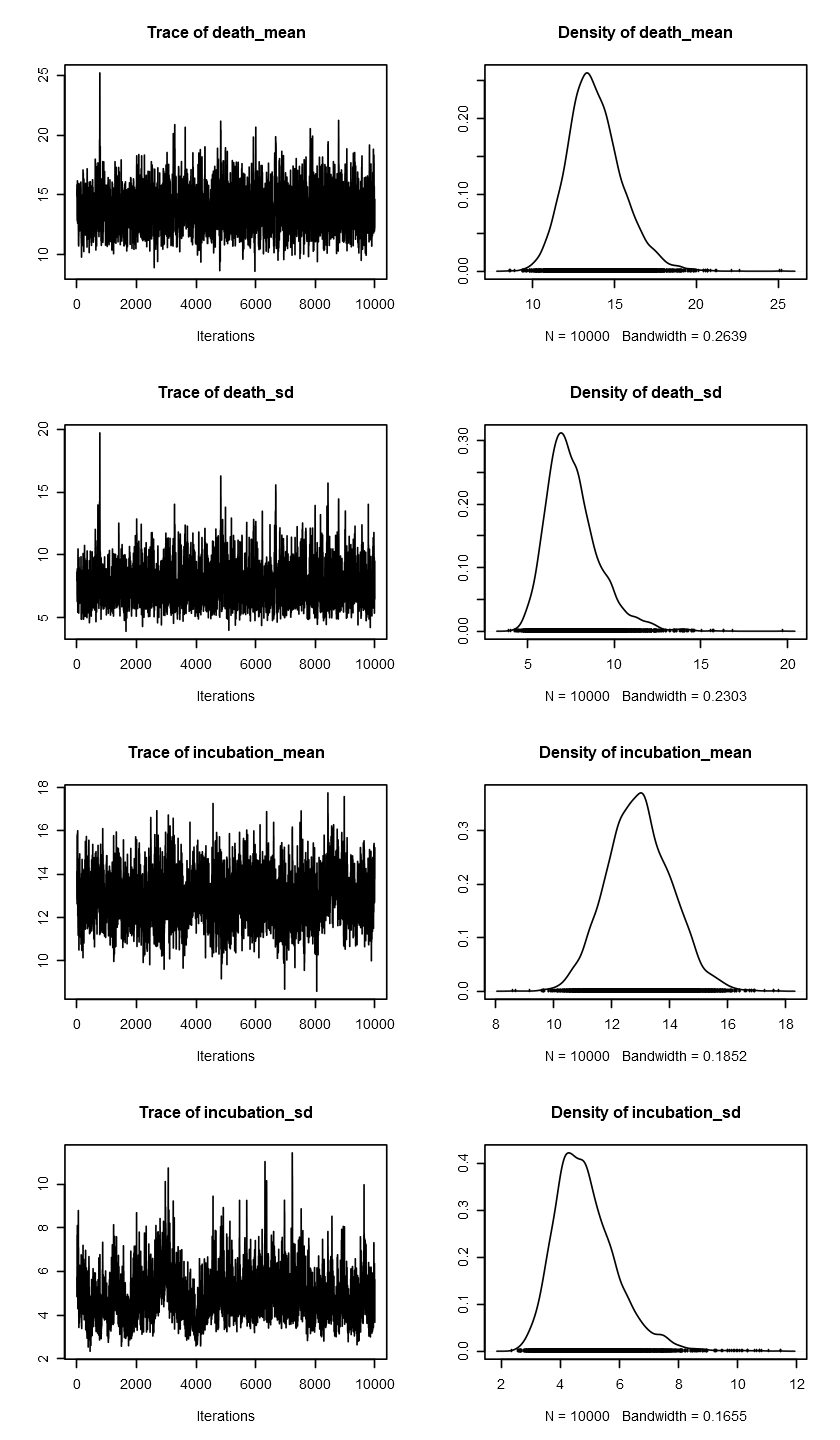

In [7]:
options(repr.plot.width=7,repr.plot.height=12)
plot(nimIncubationSamples %>% select(-contains("exposure")) %>% as.mcmc)

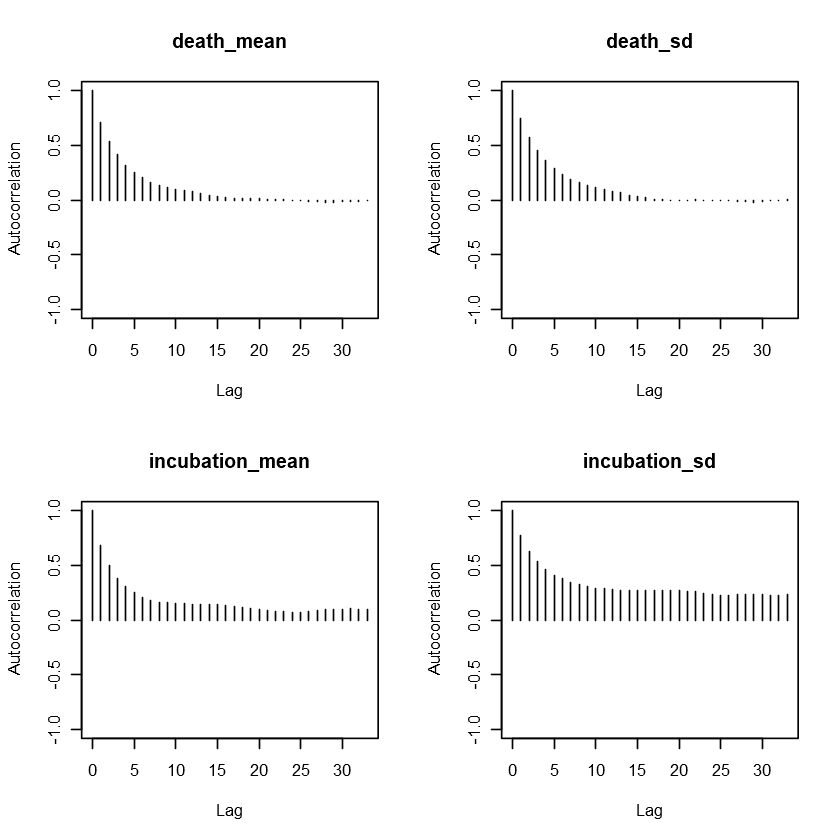

In [8]:
options(repr.plot.width=7,repr.plot.height=7)
autocorr.plot(nimIncubationSamples %>% select(-contains("exposure")) %>% as.mcmc)

# Improved convergence

In [38]:
nimIncubationConf = configureMCMC(nimIncubationModel, 
                                  monitors=c("incubation_mean","incubation_sd"), 
                                  monitors2=c("death_mean","death_sd"),
                                  monitors3=nimIncubationSamples %>% select(contains("exposure")) %>% colnames,
                                  thin = 50, thin2 = 50, thin3 = 10)

In [39]:
## Model compilation
nimIncubationMCMC = buildMCMC(nimIncubationConf)
compiledIncubationModel = compileNimble(nimIncubationModel,nimIncubationMCMC)

compiling... this may take a minute. Use 'showCompilerOutput = TRUE' to see C++ compiler details.
compilation finished.


In [61]:
Niter = 5e5
Nburn = 2e4
compiledIncubationModel$nimIncubationMCMC$run(niter=Niter+Nburn,nburn=Nburn)
compiledIncubationModel$nimIncubationMCMC$mvSamples %>% as.matrix %>% as.data.frame -> nimIncubationSamples
compiledIncubationModel$nimIncubationMCMC$mvSamples2 %>% as.matrix %>% as.data.frame -> nimIncubationSamples2

|-------------|-------------|-------------|-------------|
|-------------------------------------------------------|


NULL

In [62]:
nrow(nimIncubationSamples)

[1] 10000

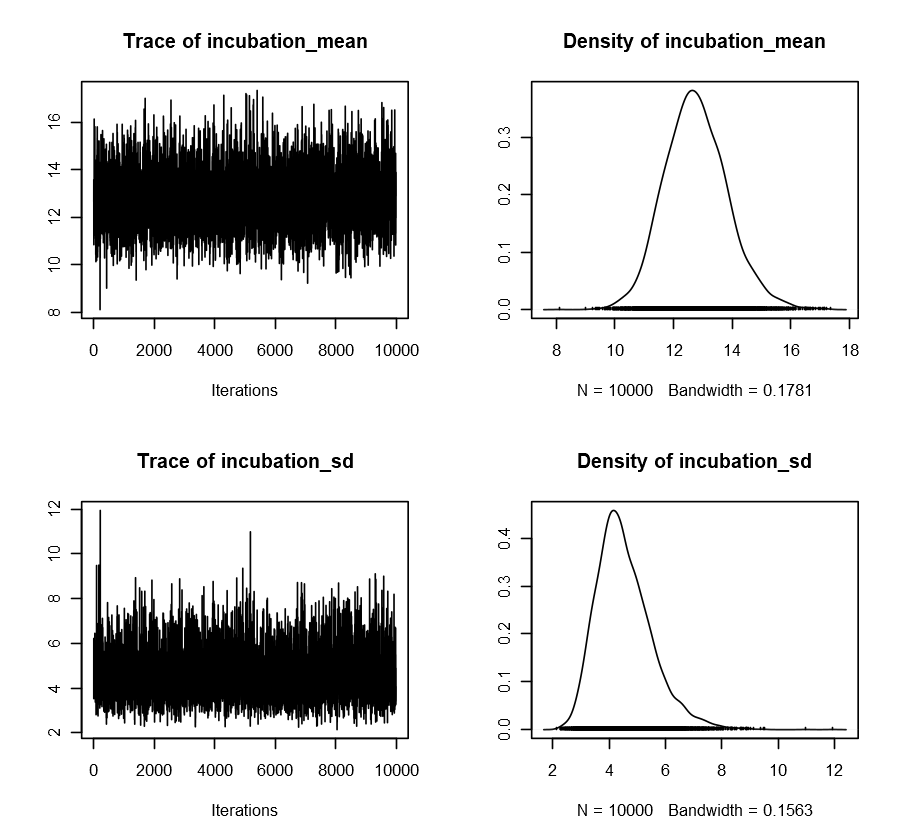

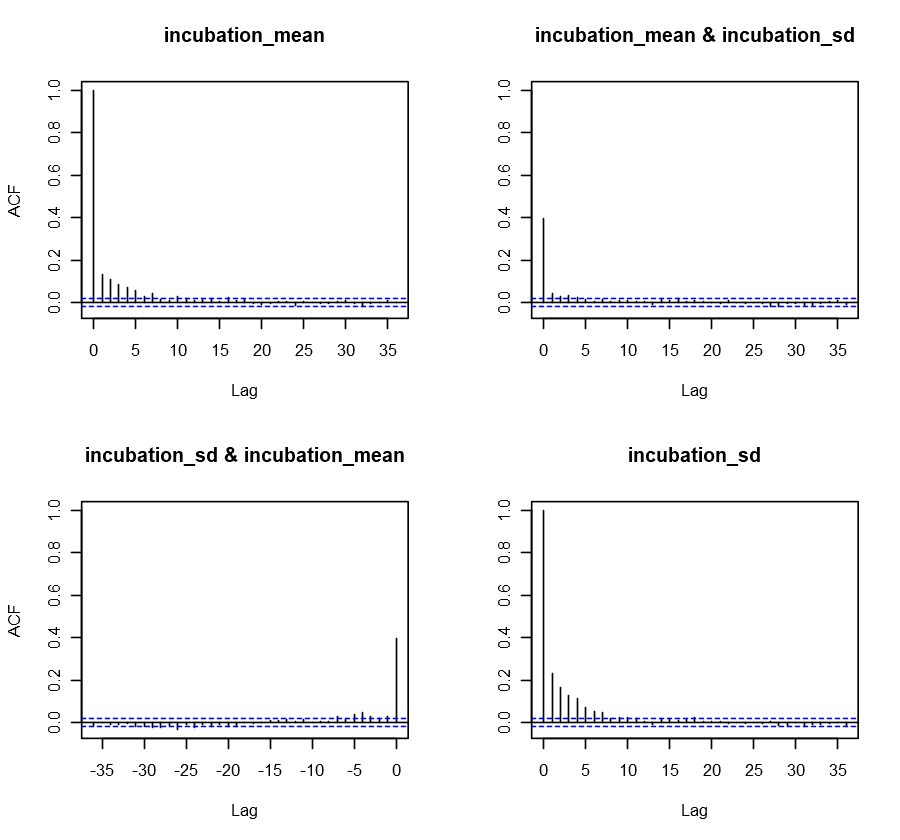

In [63]:
cs = c(7.5,7)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])
p1 = plot(nimIncubationSamples %>% as.mcmc)
p2 = acf(nimIncubationSamples %>% as.mcmc)

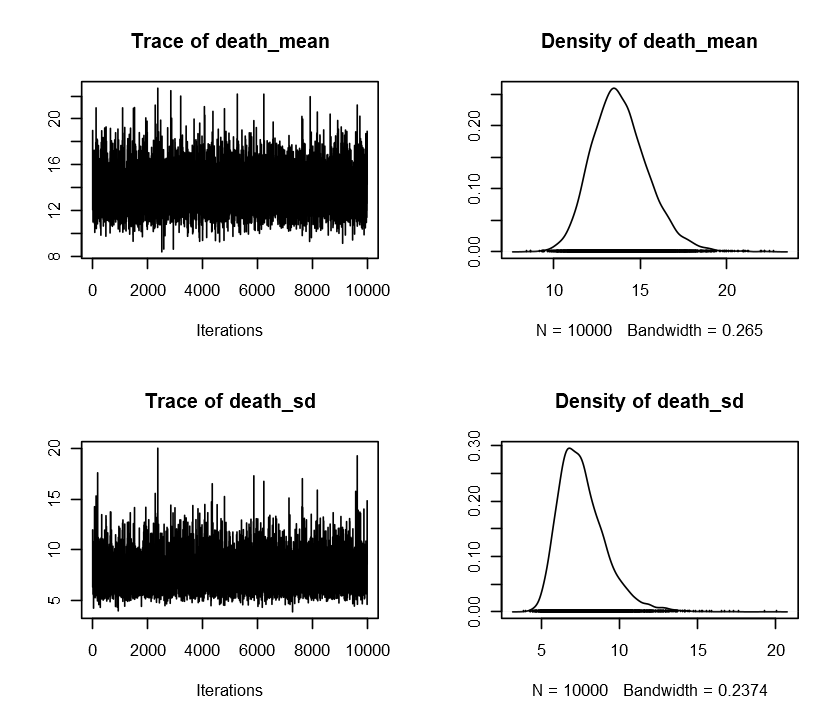

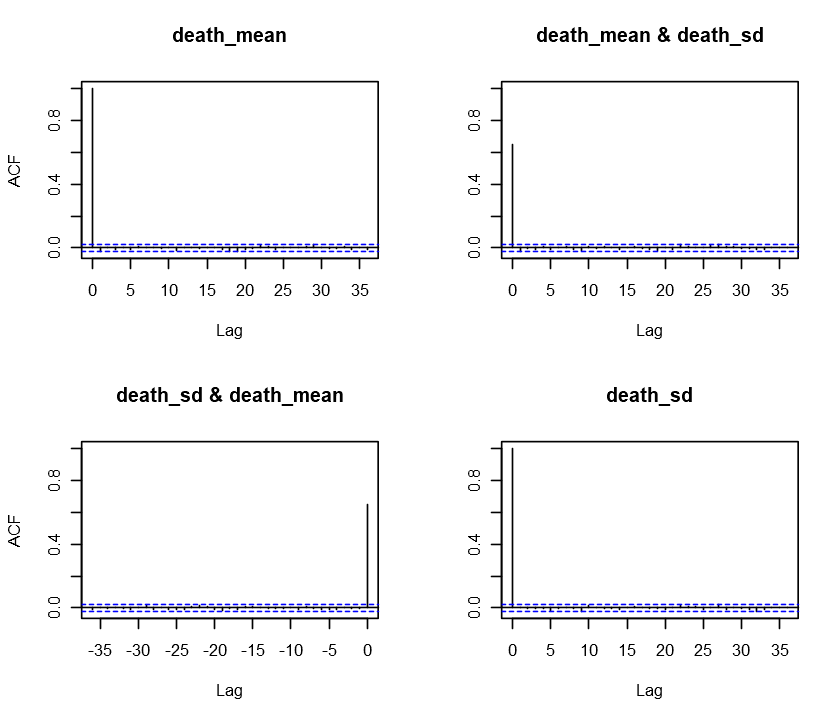

In [64]:
options(repr.plot.width=7,repr.plot.height=6)
plot(nimIncubationSamples2 %>% as.mcmc)
acf(nimIncubationSamples2 %>% as.mcmc)

In [65]:
## Credible intervals
IncubationCIs = hdi(nimIncubationSamples,.95) %>% as.data.frame %>% { tibble::rownames_to_column(.,"var") }

nimIncubationSamples %>% 
    summarise_all(funs(mean)) %>%
    mutate(var="median") %>% 
    rbind(IncubationCIs) %>% 
    select(var,everything()) -> IncubationCIs

(IncubationCIs) 

## Credible intervals
IncubationCIs2 = hdi(nimIncubationSamples2,.95) %>% as.data.frame %>% { tibble::rownames_to_column(.,"var") }

nimIncubationSamples2 %>% 
    summarise_all(funs(mean)) %>%
    mutate(var="median") %>% 
    rbind(IncubationCIs2) %>% 
    select(var,everything()) -> IncubationCIs2

(IncubationCIs2)

var,incubation_mean,incubation_sd
median,12.76804,4.541345
lower,10.71441,2.840378
upper,14.95510,6.579267


var,death_mean,death_sd
median,13.83202,7.632116
lower,10.77072,5.049845
upper,17.01862,10.637380


In [66]:
IncubationCIs %<>% left_join(IncubationCIs2)

IncubationCIs %>%
    filter(var=="median") %>%
    select(-var) -> mediansJos

mediansJos

Joining, by = "var"


incubation_mean,incubation_sd,death_mean,death_sd
12.76804,4.541345,13.83202,7.632116


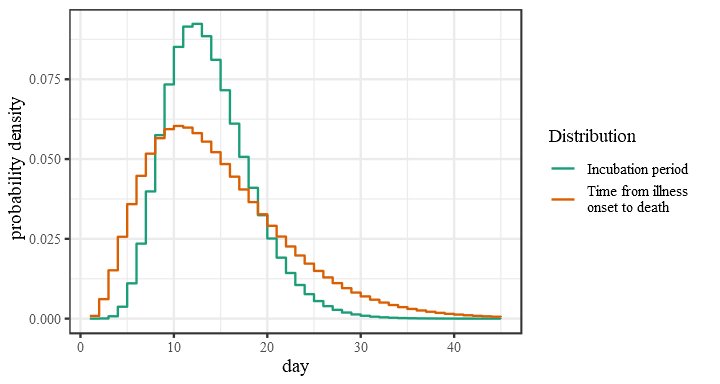

In [67]:
times = 1:45
cs = c(6,3.2)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

data.frame(x=times,
           `Incubation Period`=pgamma(times,shape=mediansJos$incubation_mean^2/mediansJos$incubation_sd^2,
                    rate=mediansJos$incubation_mean/mediansJos$incubation_sd^2)-
               pgamma(times-1,shape=mediansJos$incubation_mean^2/mediansJos$incubation_sd^2,
                      rate=mediansJos$incubation_mean/mediansJos$incubation_sd^2),
          `Time from Onset to Death`=pgamma(times,shape=mediansJos$death_mean^2/mediansJos$death_sd^2,
                    rate=mediansJos$death_mean/mediansJos$death_sd^2)-
               pgamma(times-1,shape=mediansJos$death_mean^2/mediansJos$death_sd^2,
                      rate=mediansJos$death_mean/mediansJos$death_sd^2)) %>%
    gather(Variable,y,-x) %>%
    ggplot(aes(x=x,y=y)) +
        geom_step(aes(color=Variable)) +
        scale_color_manual(labels = c("Incubation period", "Time from illness\nonset to death"), values=clrs) +
        labs(x="day",y="probability density",color="Distribution") -> p

p

ggsave(plot=p,width=cs[1],height=cs[2],filename="../figures/FigS1.pdf", useDingbats=FALSE)

**Reported stages of Lassa fever:**
<img src="../data/stages.png" style="width: 50%;"/>
As we see the time to death is usually above 14 days

In [68]:
# Percentiles for incubation period
qgamma(c(.025,.975),
       shape=mediansJos$incubation_mean^2/mediansJos$incubation_sd^2,
       rate=mediansJos$incubation_mean/mediansJos$incubation_sd^2)

[1]  5.478673 23.088104

In [69]:
# Percentiles for time to death
qgamma(c(.025,.975),
       shape=mediansJos$death_mean^2/mediansJos$death_sd^2,
       rate=mediansJos$death_mean/mediansJos$death_sd^2)

[1]  3.137071 32.310130

## Final outcomes

In [70]:
# Incubation period = gamma distribution
message("incubation_mean")
mediansJos$incubation_mean
message("incubation_sd")
mediansJos$incubation_sd

incubation_shape = mediansJos$incubation_mean^2/mediansJos$incubation_sd^2
incubation_rate = mediansJos$incubation_mean/mediansJos$incubation_sd^2*7.0 #from days to weeks
message("incubation shape and scale")
print(c(incubation_shape,1/incubation_rate))

# Time from Onset to Death
message("period_to_death_mean")
mediansJos$death_mean
message("period_to_death_sd")
mediansJos$death_sd
death_shape = mediansJos$death_mean^2/mediansJos$death_sd^2
death_rate = mediansJos$death_mean/mediansJos$death_sd^2*7.0 #from days to weeks
message("period_to_death shape and scale")
print(c(death_shape,1/death_rate))

incubation_mean


[1] 12.76804

incubation_sd


[1] 4.541345

incubation shape and scale


[1] 7.9045911 0.2307527


period_to_death_mean


[1] 13.83202

period_to_death_sd


[1] 7.632116

period_to_death shape and scale


[1] 3.2845903 0.6015979


# Loading the data

In [71]:
yearMin = 2016

data = read_excel("../data/Nigeria_raw.xlsx", sheet = "Incidence") %>%
    select(-one_of("Timeseries","Imputation","File in the repo"),-contains("URL")) %>%
    filter(Year>=yearMin) %>%
    group_by(Year) %>%
    mutate(Incidence_Reported = if_else(Week==1,Reported,Reported-lead(Reported)), 
           Incidence_Deaths = if_else(Week==1,Deaths,Deaths-lead(Deaths))
          ) %>%
    ungroup

data %>% tail

Year,Week,LGAs,States,Reported,Deaths,Confirmed,Positive_Incidence,Negative_Incidence,Incidence_Reported,Incidence_Deaths
2016,6,93,24,377,60,35,NA,NA,35,3
2016,5,83,23,342,57,32,NA,NA,22,4
2016,4,NA,NA,320,53,NA,NA,NA,NA,19
2016,3,NA,NA,NA,34,NA,NA,NA,NA,NA
2016,2,NA,NA,NA,NA,NA,NA,NA,NA,NA
2016,1,NA,NA,NA,NA,NA,NA,NA,NA,NA


# MCMC simulations for the main dataset on incidence

In [66]:
data %>% select(Year,Week,starts_with("Incidence")) -> Df

Df %>% head

Year,Week,Incidence_Reported,Incidence_Deaths
2018,30,16,0
2018,29,33,3
2018,28,15,1
2018,27,20,2
2018,26,12,0
2018,25,24,2


In [67]:
data.frame(Year=yearMin-1,Week=1:52,Incidence_Reported=NA,Incidence_Deaths=NA) %>% 
    rbind(Df %>% arrange(Year,Week)) %>%
    rowwise %>% 
    mutate(Incidence_Reported_NA=ifelse(is.na(Incidence_Reported),rpois(1,30),NA),
           Incidence_Deaths_NA=ifelse(is.na(Incidence_Deaths),rpois(1,1),NA)) %>%
    ungroup -> Df

K = nrow(Df)

# Convolutions
incubation_probability = pgamma(1:K,shape=incubation_shape,rate=incubation_rate)-pgamma(1:K-1,shape=incubation_shape,rate=incubation_rate)
timeFromOnsetToDeath_probability = pgamma(1:K,shape=death_shape,rate=death_rate)-pgamma(1:K-1,shape=death_shape,rate=death_rate)
# time from Exposure event to Death is the convolution of two latter probabilities
timeFromExposureToDeath_probability = c(0)
for (x in 2:K) {
    timeFromExposureToDeath_probability = c(timeFromExposureToDeath_probability,
        sum(incubation_probability[1:(x-1)]*timeFromOnsetToDeath_probability[(x-1):1]))
}

## First run of MCMC

In [70]:
recalc = F

shift = 26

nimData = list(infected = Df$Incidence_Reported,
               dead = Df$Incidence_Deaths,
               one = 1)

nimConsts = list(r = rho,
                 K = K,
                 week = (Df$Week-shift-1)%%52+1,
                 incubationPeriod = incubation_probability[1:K],
                 periodToDeath = timeFromExposureToDeath_probability[1:K])

nimInits = function(){
    list(l1 = (runif(1,44,52)-shift-1)%%52+1,
         l2 = (runif(1,5,12)-shift-1)%%52+1,
         infected = Df$Incidence_Reported_NA,
         dead = Df$Incidence_Deaths_NA,
         lambdaIncidence = rep(0,K),
         lambdaDeath = rep(0,K),
         exposure = rgamma(K,10,1),
         CFR = rgamma(K,0.08,1),
         mean_a = c(rgamma(1,25,1),rgamma(1,5,1)),
         sd_a = rgamma(2,1,1),
         mean_q = rbeta(1,1,1),
         sd_q = rbeta(1,1,1))}

nimConvolution = nimbleFunction(
    run = function(a = double(1), b = double(1)) {
        L <- dim(a)[1]
        ans <- inprod(a[L+1-1:L],b)
        return(ans)
        returnType(double(0))
    }
)

nimCode = nimbleCode({
    ## exposure and awareness
    for (k in 1:K) {
        mean_a_realized[k] <- mean_a[1]+(mean_a[2]-mean_a[1])*equals(step(week[k]-l1),step(l2-week[k]))
        sd_a_realized[k] <- sd_a[1]+(sd_a[2]-sd_a[1])*equals(step(week[k]-l1),step(l2-week[k]))
        exposure[k] ~ dgamma(mean=mean_a_realized[k],sd=sd_a_realized[k])
        CFR[k] ~ dgamma(mean=mean_q,sd=sd_q)
    }
    ### I start from week 53 because the first 52 weeks were added with missing data
    ### in order to avoid edge effects for the convolution
    for (k in 52:(K-1)) {
        lambdaIncidence[k+1] <- nimConvolution(exposure[1:k],incubationPeriod[1:k])/(1-r)
        lambdaDeath[k+1] <- CFR[k+1]*nimConvolution(exposure[1:k],periodToDeath[1:k])/(1-r)
        infected[k+1] ~ dpois(lambdaIncidence[k+1])
        dead[k+1] ~ dpois(lambdaDeath[k+1])
    }
    ## Priors
    for(i in 1:2) {
        mean_a[i] ~ dinvgamma(0.001, 0.001)
        sd_a[i] ~ dinvgamma(0.001, 0.001)
    }
    mean_q ~ dinvgamma(0.001, 0.001)
    sd_q ~ dinvgamma(0.001, 0.001)
    l1 ~ dunif(0,53)
    l2 ~ dunif(0,53)
    one ~ dbern(condition)
    condition <- step(l2-l1-2)
})

nimModel = nimbleModel(nimCode,
                       constants = nimConsts,
                       data = nimData,
                       inits = nimInits())

if (recalc==TRUE) {
    nimConf = configureMCMC(nimModel,setSeed=TRUE,control=list(reflective=TRUE))
    nimConf$addMonitors(c('l2'))
    ## Checking that all variables are properly initialized
    nimModel$initializeInfo()
    
    ## Model compilation
    nimMCMC = buildMCMC(nimConf)
    compiledModel = compileNimble(nimModel,nimMCMC)
    
    Niter = 2e4
    Nburn = 1e4
    compiledModel$nimMCMC$run(niter=Niter+Nburn, nburnin = Nburn)
    compiledModel$nimMCMC$mvSamples %>% as.matrix %>% as.data.frame -> nimSamples

    saveRDS(nimSamples, file = "nimSamples_first_run_from_2016.rds")
} else {
    readRDS(file = "nimSamples_first_run_from_2016.rds") -> nimSamples
}
    
nimSamples %>% head

defining model...
Adding incubationPeriod,periodToDeath as data for building model.
building model...
setting data and initial values...
running calculate on model (any error reports that follow may simply reflect missing values in model variables) ... 
checking model sizes and dimensions...
model building finished.


l1,l2,mean_a[1],mean_a[2],mean_q,sd_a[1],sd_a[2],sd_q
23.64392,33.36837,9.120769,32.02025,0.1364619,13.16872,42.36467,0.1752596
23.15249,33.36837,9.844882,32.02025,0.1210763,13.16872,38.15339,0.1613022
25.05147,33.36837,9.844882,32.02025,0.1226371,13.16872,38.15339,0.1613022
25.05147,33.47912,9.141500,34.57901,0.1204716,13.16872,36.51836,0.1667061
25.05147,33.61571,10.351249,37.46228,0.1204716,13.16872,36.51836,0.1667061
25.05147,33.61571,10.351249,37.46228,0.1237401,15.57827,33.17100,0.1738146


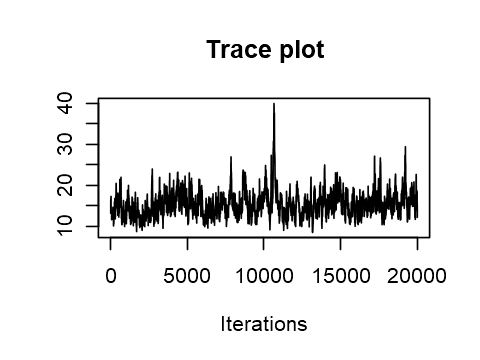

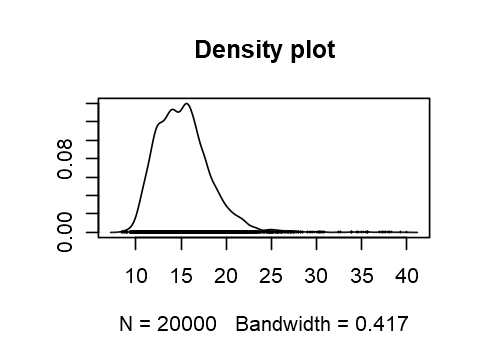

In [72]:
options(repr.plot.width=4,repr.plot.height=3)

traceplot(as.mcmc(nimSamples)[,'sd_a[1]'], main = "Trace plot")
densplot(as.mcmc(nimSamples)[,'sd_a[1]'], main = "Density plot")

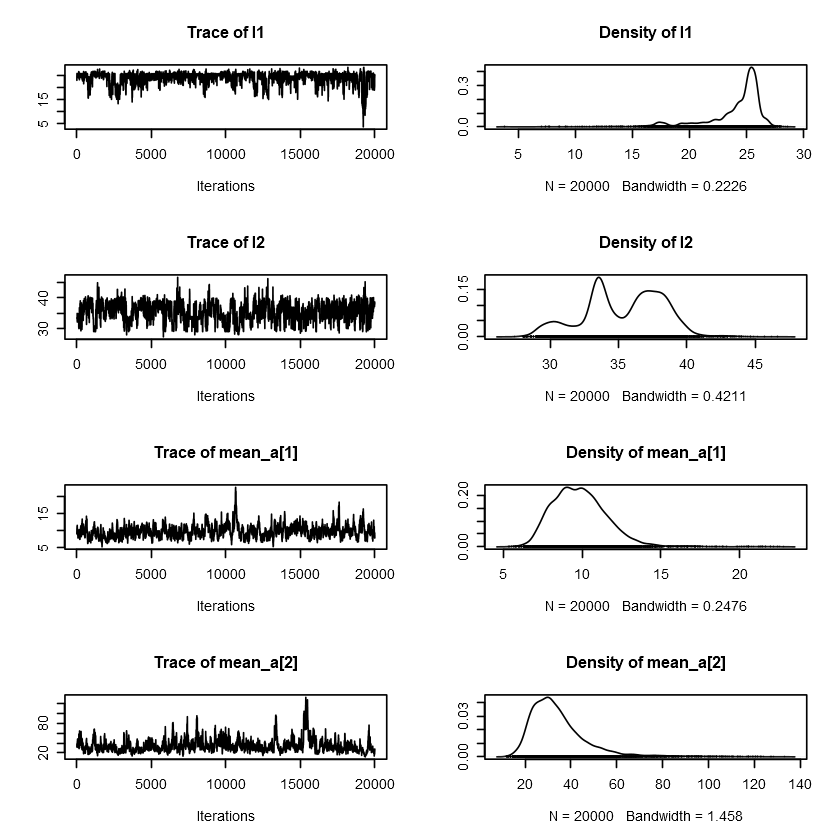

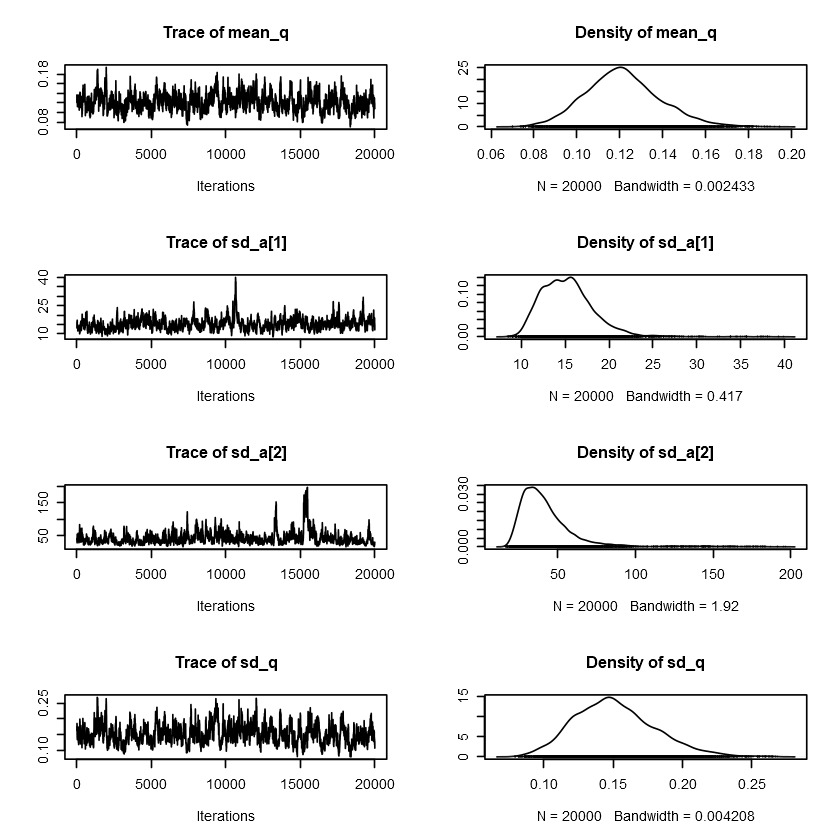

In [73]:
options(repr.plot.width=7,repr.plot.height=7)
plot(as.mcmc(nimSamples))

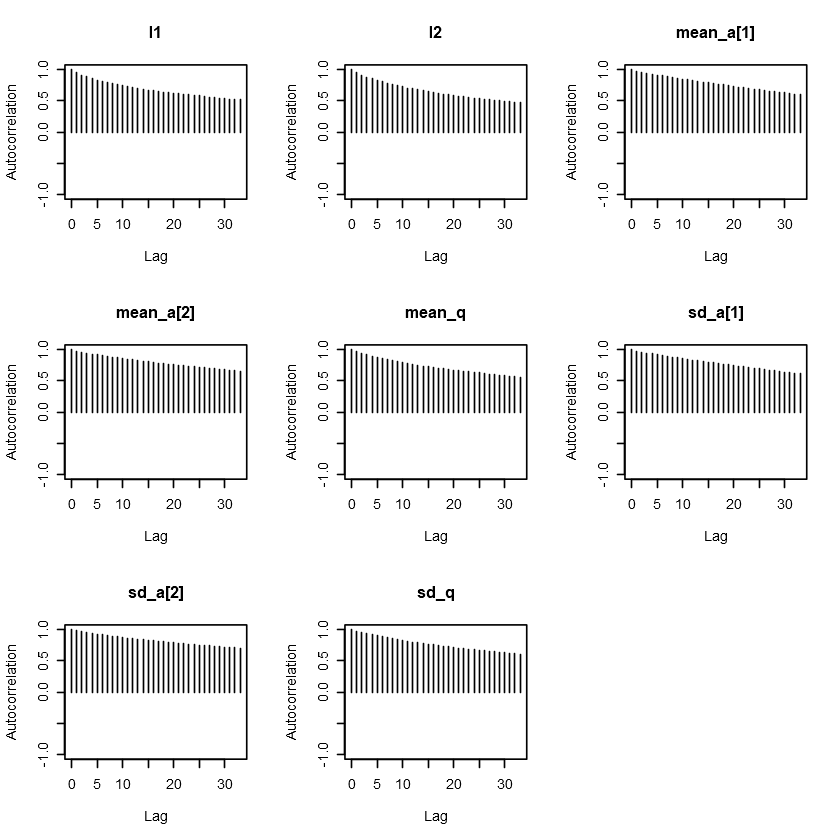

In [74]:
autocorr.plot(as.mcmc(nimSamples))

In [75]:
effectiveSize(as.mcmc(nimSamples)) 

l1        l2 mean_a[1] mean_a[2]    mean_q   sd_a[1]   sd_a[2]      sd_q 
194.79479 237.94112 142.80974 125.99553 175.24841 139.44406  93.10897 156.57192

## Implementing improved thinning & multiple chains

In [109]:
rdsFiles = list.files("./MCMC/",pattern="n*.rds")
(rdsFiles)
grep('s-[1-9]',rdsFiles,value=TRUE)[c(1:5)] -> rdsFiles
rdsFiles

shift = 26

[1] "nimSamples-1.rds" "nimSamples-2.rds" "nimSamples-3.rds" "nimSamples-4.rds"
[5] "nimSamples-5.rds"

[1] "nimSamples-1.rds" "nimSamples-2.rds" "nimSamples-3.rds" "nimSamples-4.rds"
[5] "nimSamples-5.rds"

In [110]:
nimSamples = NULL
for (k in 1:length(rdsFiles)) { #
    nimSamples %<>% rbind(readRDS("./MCMC/"%&%rdsFiles[k]))
}
nimSamples %>% head

l1,l2,mean_a[1],mean_a[2],mean_q,sd_a[1],sd_a[2],sd_q
17.39481,38.92566,8.323053,23.69997,0.1180381,14.42329,30.33545,0.1537912
24.40872,34.02333,9.701258,32.43990,0.1174793,16.46670,36.74360,0.1485331
25.79458,33.35897,10.769205,32.93839,0.1107136,17.55857,35.25451,0.1336355
22.29849,33.03704,10.390973,29.14650,0.1188369,17.62769,49.20598,0.1705338
25.87067,33.99958,8.749835,33.04915,0.1292944,12.39500,23.24543,0.1631600
18.05684,31.80091,14.609152,20.85199,0.1156732,23.50352,27.39365,0.1324366


In [111]:
nimSamples %>% nrow

[1] 10000

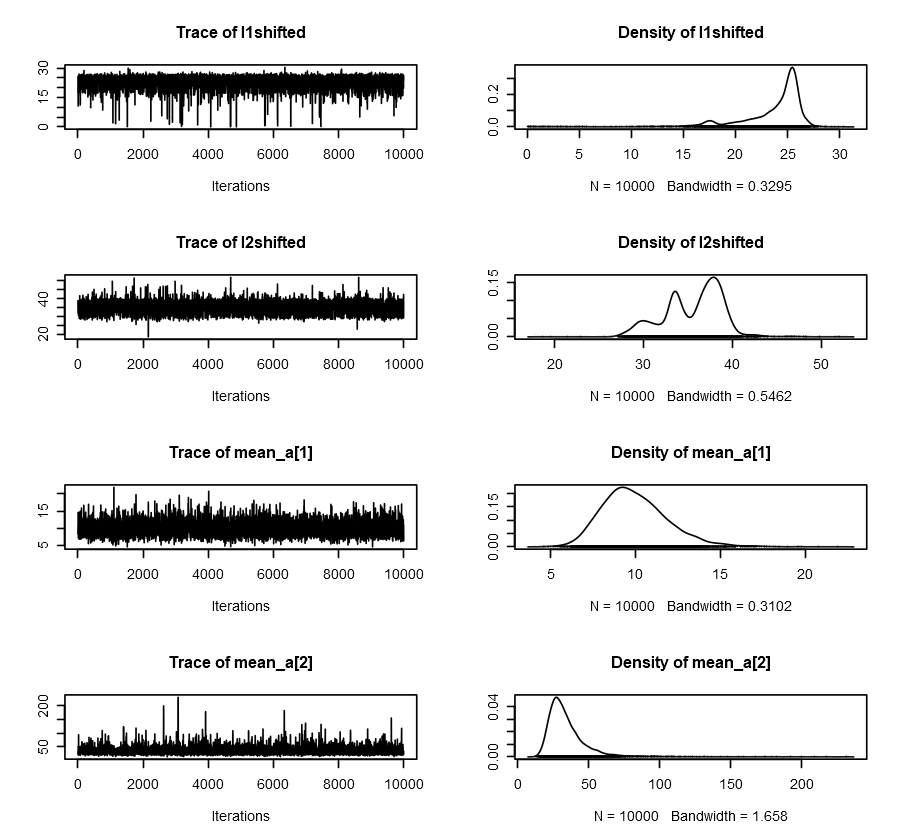

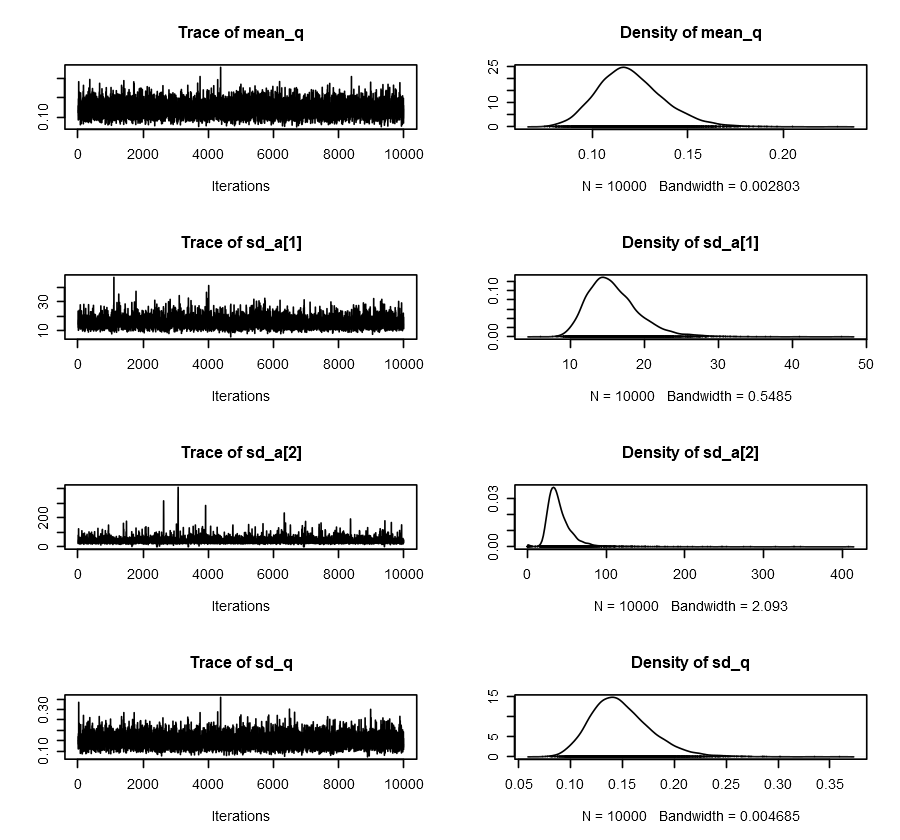

In [101]:
options(repr.plot.width=7.5,repr.plot.height=7)
plot(nimSamples %>%
#      mutate(l1 = (l1+shift-1)%%52+1, l2 = (l2+shift-1)%%52+1) %>% #
     rename(l1shifted = l1, l2shifted = l2) %>% 
     as.mcmc)

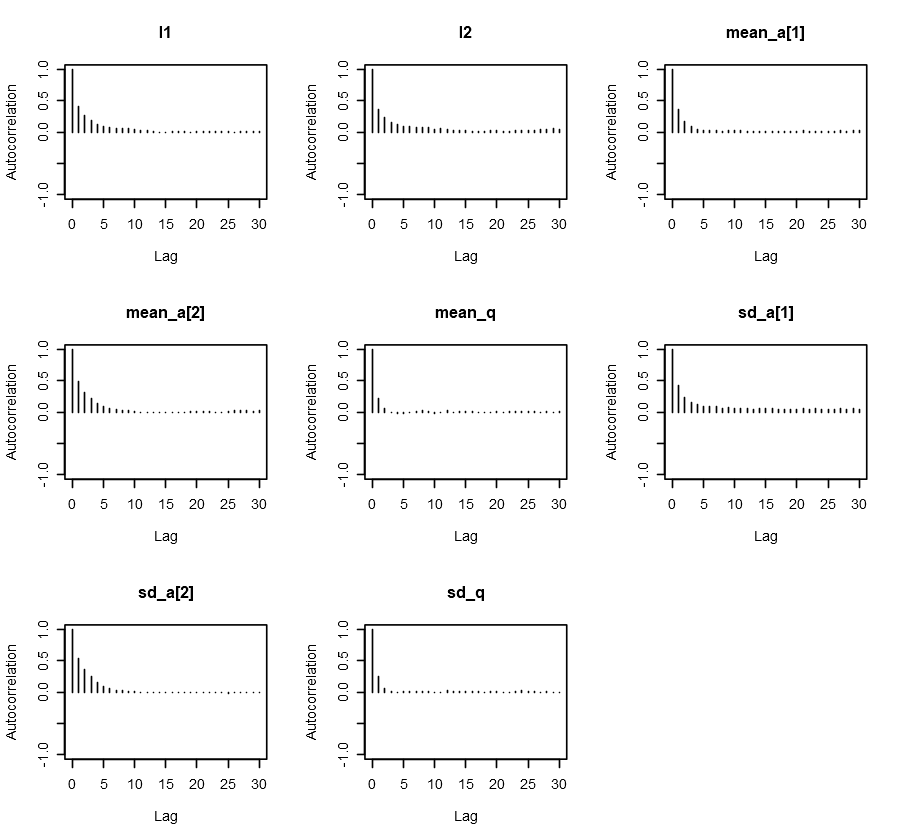

In [102]:
autocorr.plot(as.mcmc(nimSamples))

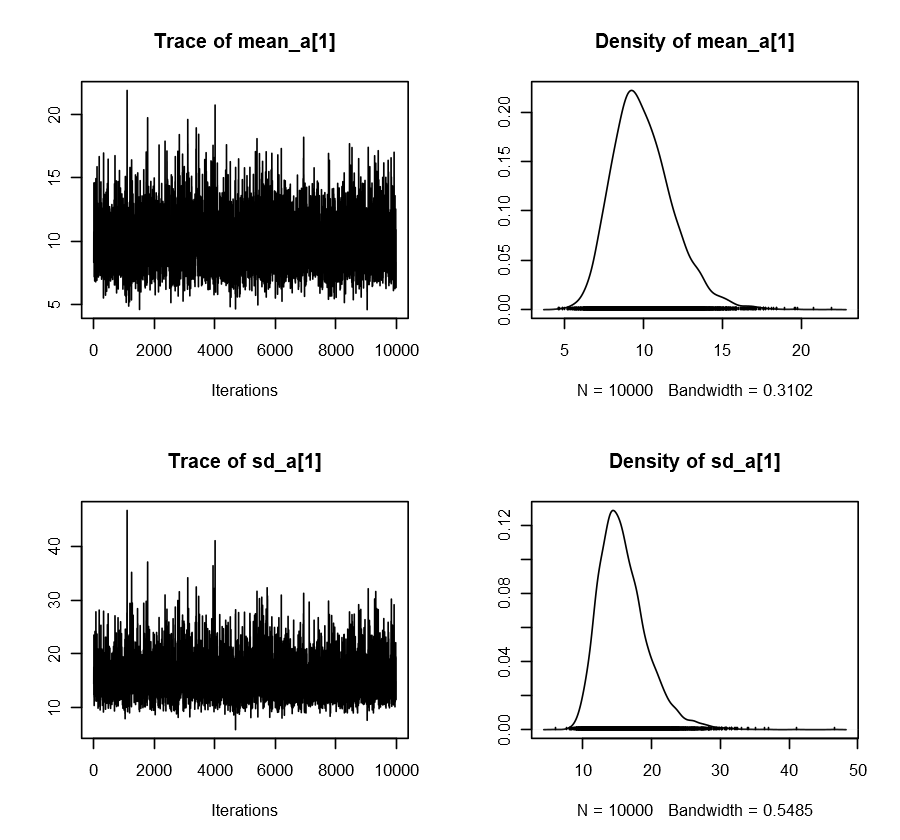

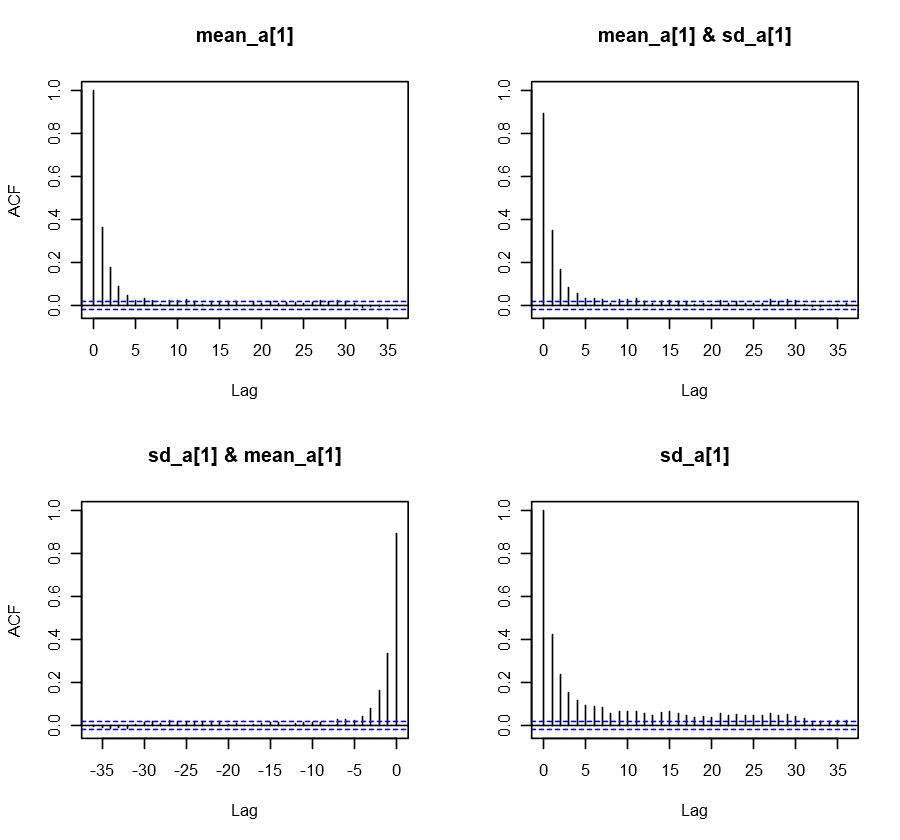

In [103]:
cs = c(7.5,7)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])
plot(as.mcmc(nimSamples[,c('mean_a[1]','sd_a[1]')]))
acf(as.mcmc(nimSamples[,c('mean_a[1]','sd_a[1]')]))

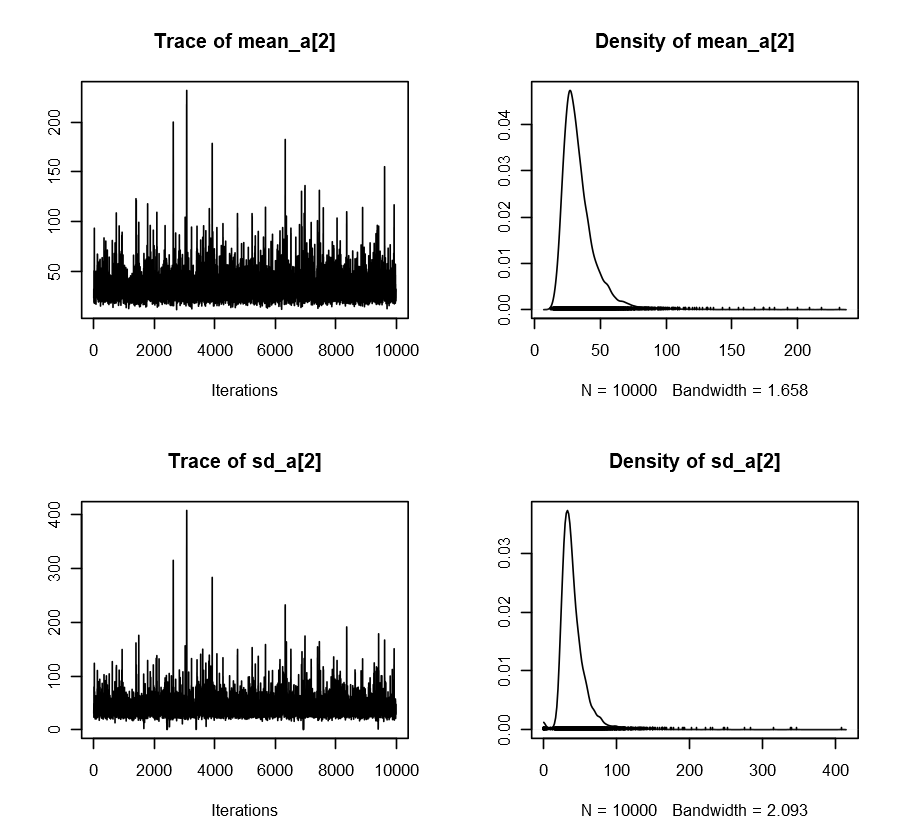

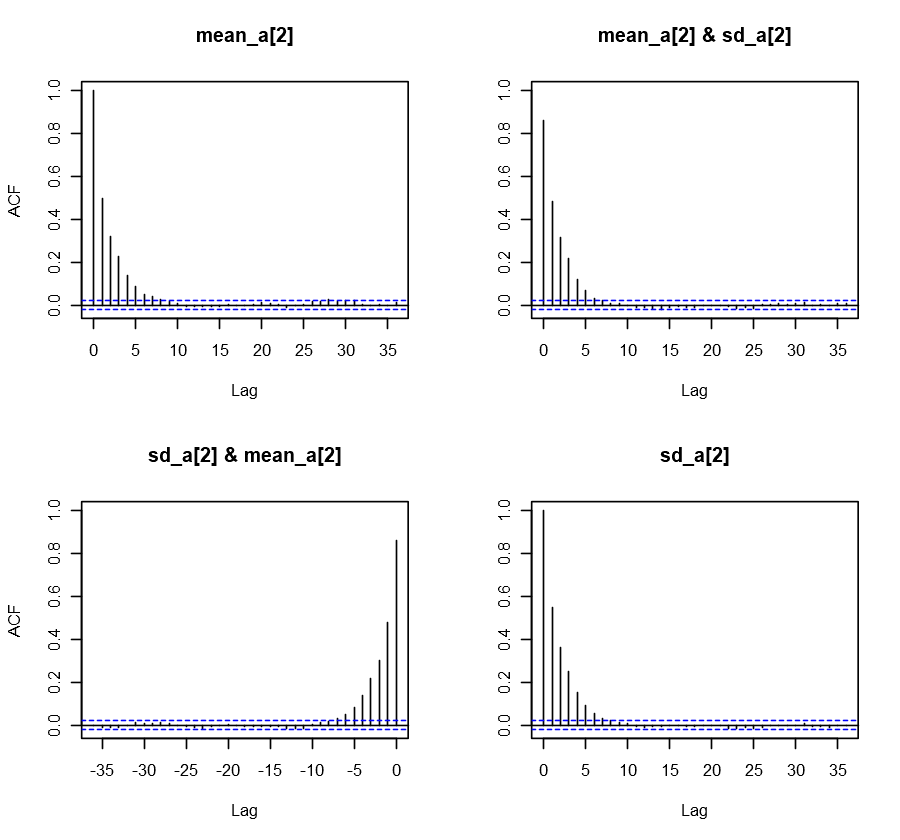

In [104]:
cs = c(7.5,7)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])
plot(as.mcmc(nimSamples[,c('mean_a[2]','sd_a[2]')]))
acf(as.mcmc(nimSamples[,c('mean_a[2]','sd_a[2]')]))

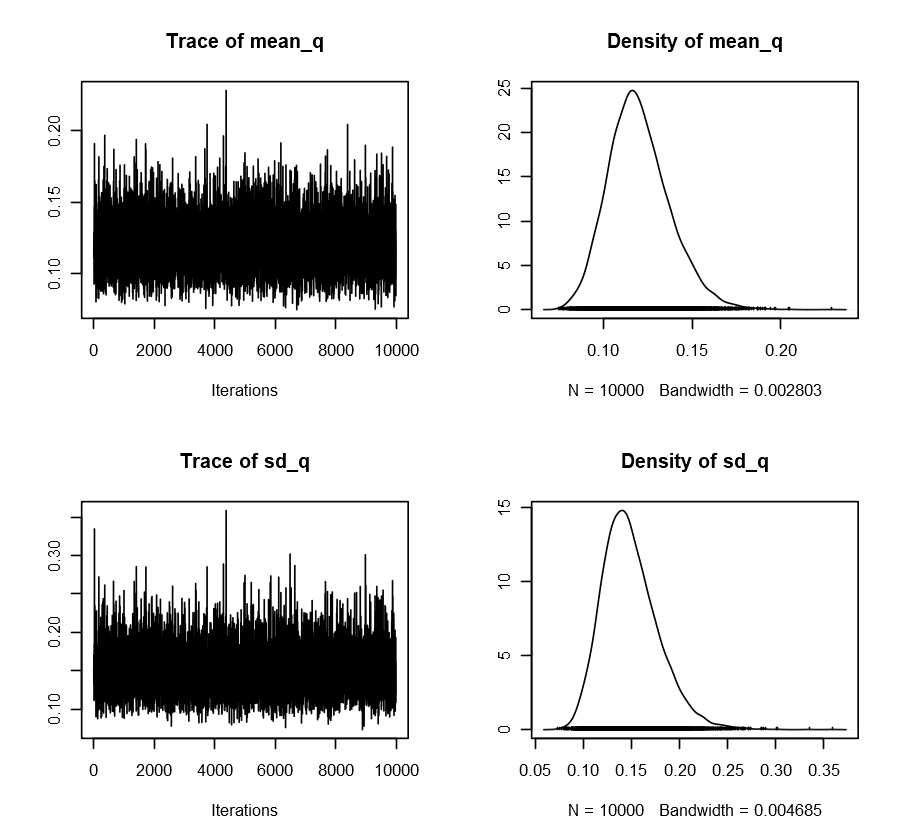

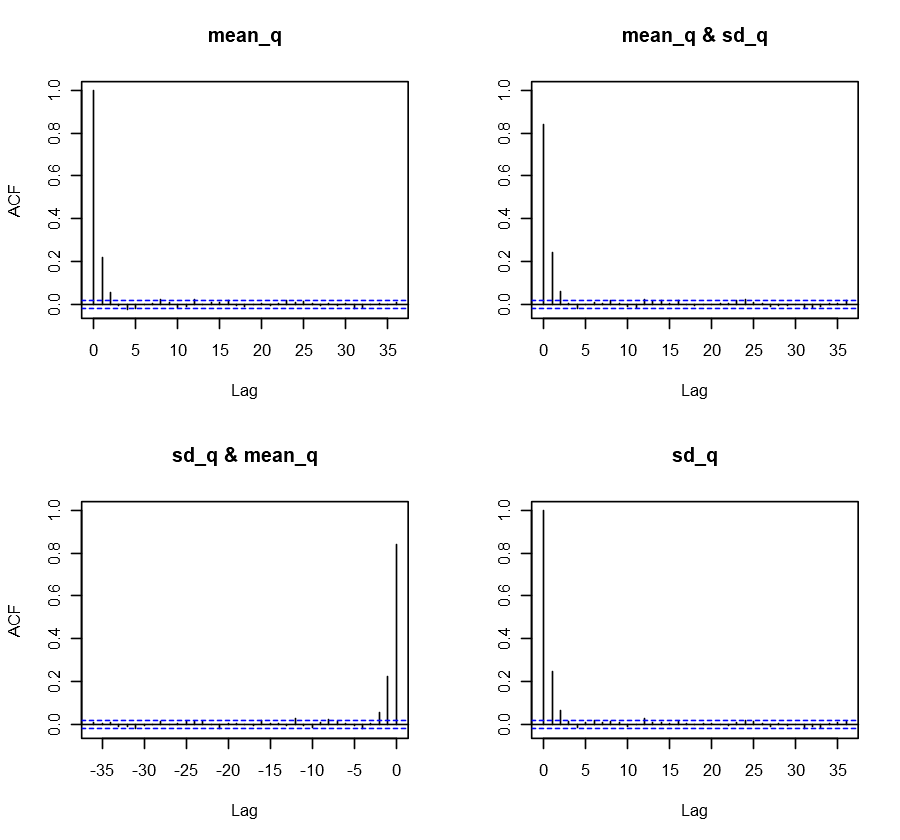

In [105]:
cs = c(7.5,7)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])
plot(as.mcmc(nimSamples[,c('mean_q','sd_q')]))
acf(as.mcmc(nimSamples[,c('mean_q','sd_q')]))

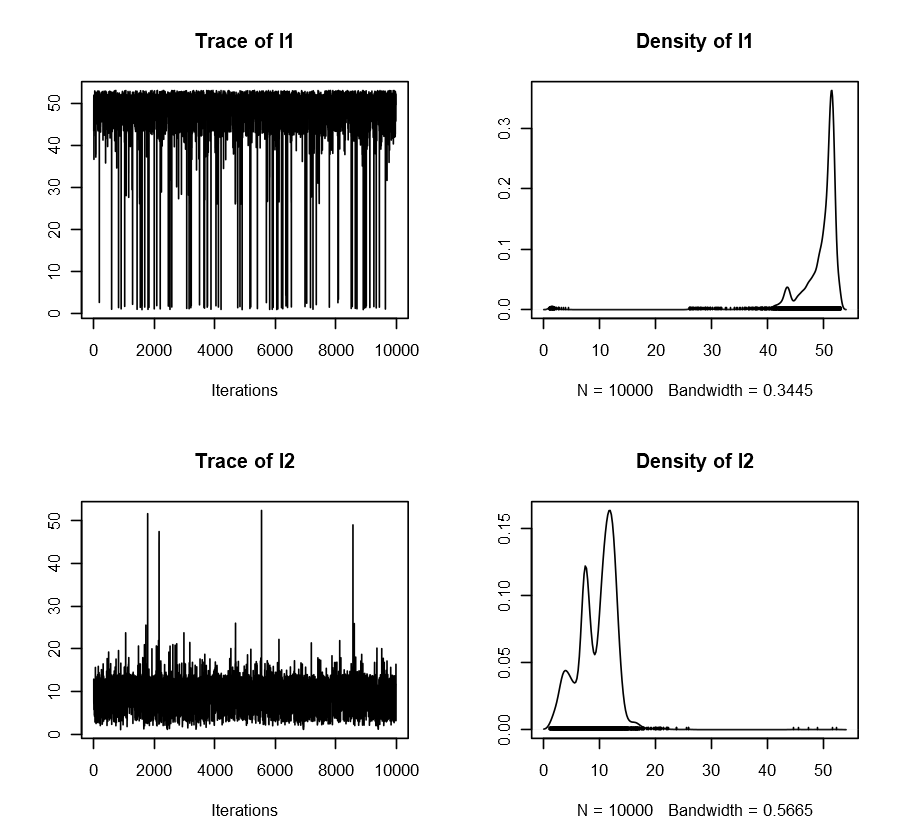

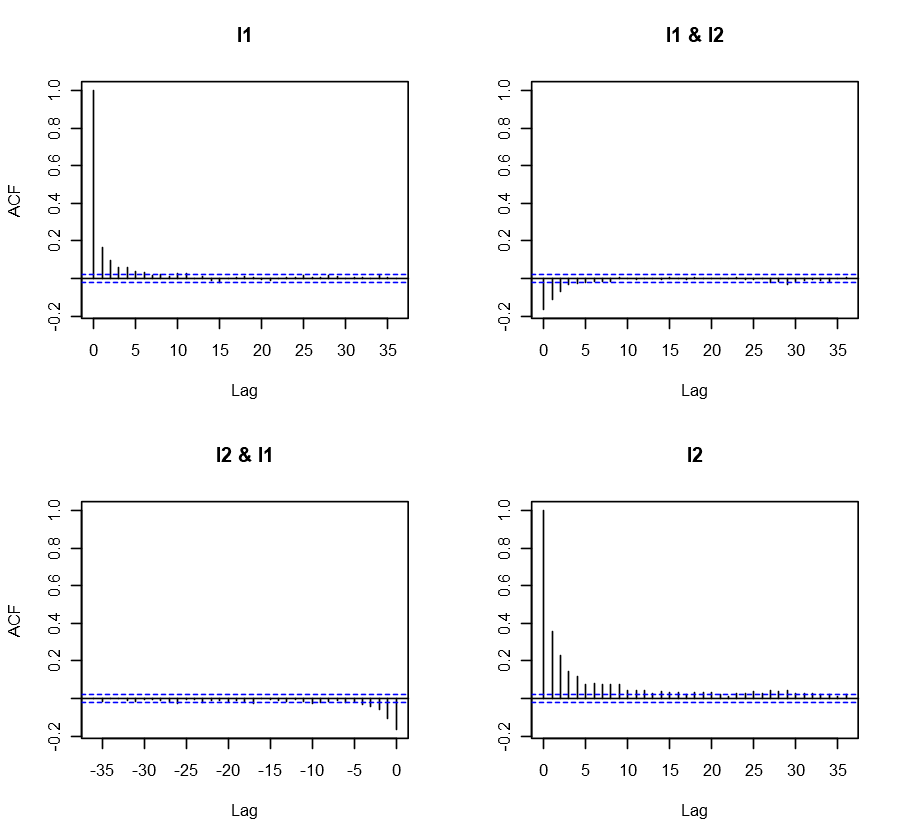

In [106]:
cs = c(7.5,7)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])
nimSamples %>%
    mutate(l2s = (l1+shift-1)%%52+1, l1s = (l2+shift-1)%%52+1) %>% 
    select(-l1,-l2) %>% rename(l2=l1s, l1=l2s) %>% 
    .[,c('l1','l2')] %>% as.mcmc %>% 
    plot

nimSamples %>% 
    mutate(l2s = (l1+shift-1)%%52+1, l1s = (l2+shift-1)%%52+1) %>% 
    select(-l1,-l2) %>% rename(l2=l1s, l1=l2s) %>% 
    .[,c('l1','l2')] %>% as.mcmc %>%
    acf

In [107]:
effectiveSize(as.mcmc(nimSamples)) 

l1        l2 mean_a[1] mean_a[2]    mean_q   sd_a[1]   sd_a[2]      sd_q 
 2396.169  2396.524  4219.969  2529.000  6447.258  1992.032  2422.278  6055.889

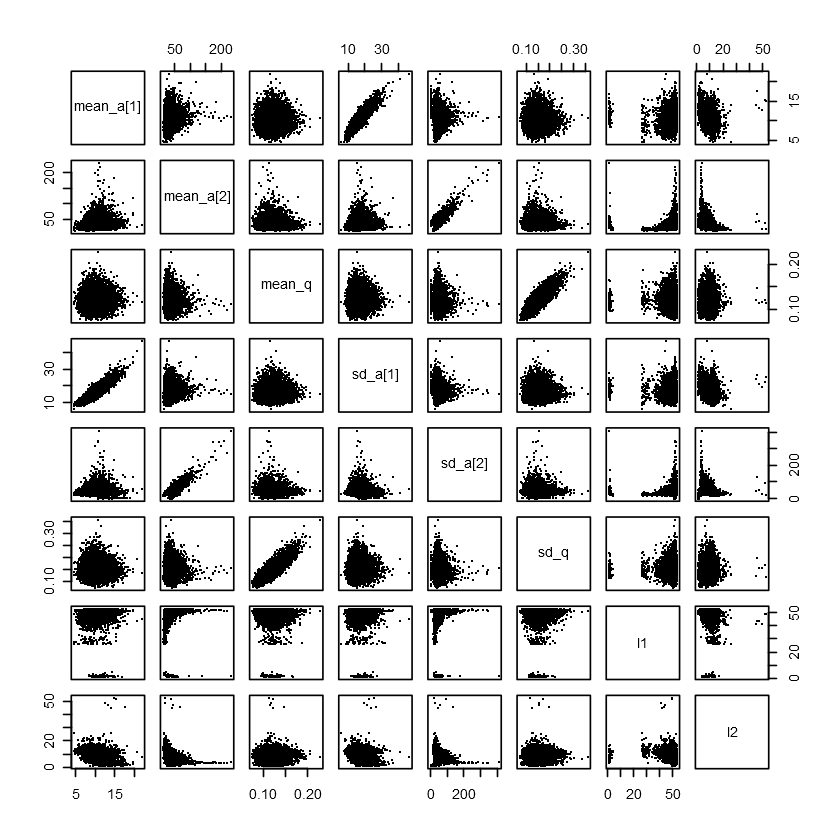

In [108]:
options(repr.plot.width=7,repr.plot.height=7)

nimSamples %>% 
    mutate(l2s = (l1+shift-1)%%52+1, l1s = (l2+shift-1)%%52+1) %>% 
    select(-l1,-l2) %>% rename(l2=l1s, l1=l2s) %>%
    pairs(pch = '.')

In [237]:
meansParams = colMeans(nimSamples)
meansParams

l1         l2  mean_a[1]  mean_a[2]     mean_q    sd_a[1]    sd_a[2] 
23.6418986 35.5843142  9.9668347 34.0423625  0.1201845 15.8575370 41.5592042 
      sd_q 
 0.1490278

In [238]:
CInarrow = .75
CIwide = .95

# nimSamples %<>% mutate(`mean_a[1]`=low_mean_a,`mean_a[2]`=low_mean_a+delta_mean_a)

exposure_cat = c("exposure1","exposure2")
resultMCMC0 = NULL
for(index in 1:2) {
    df__ = rgamma(nrow(nimSamples),
                  shape=nimSamples[,paste0('mean_a[',index,']')]^2/nimSamples[,paste0('sd_a[',index,']')]^2,
                  rate=nimSamples[,paste0('mean_a[',index,']')]/nimSamples[,paste0('sd_a[',index,']')]^2) 
    credIntervalsNarrow = hdi(df__,CInarrow)
    credIntervalsWide = hdi(df__,CIwide)
    resultMCMC0 %<>% rbind(c(exposure_cat[index],
                            credIntervalsWide[[1]],credIntervalsNarrow[[1]],
                            quantile(df__, c(.5)),
                            credIntervalsNarrow[[2]],credIntervalsWide[[2]],mean(df__)))
}

df__ = rgamma(nrow(nimSamples),
              shape=nimSamples[,'mean_q']/nimSamples[,'sd_q']^2,
              rate=nimSamples[,'mean_q']^2/nimSamples[,'sd_q']^2) 
credIntervalsNarrow = hdi(df__,CInarrow)
credIntervalsWide = hdi(df__,CIwide)
resultMCMC0 %<>% rbind(c("CFR",
                        credIntervalsWide[[1]],credIntervalsNarrow[[1]],
                        quantile(df__, c(.5)),
                        credIntervalsNarrow[[2]],credIntervalsWide[[2]],mean(df__)))

for (i0 in c('l1','l2')) {
    df__ = nimSamples %>% 
        mutate(l1 = (l1+shift-1)%%52+1, l2 = (l2+shift-1)%%52+1) %>% .[,i0] 
    credIntervalsNarrow = hdi(df__,CInarrow)
    credIntervalsWide = hdi(df__,CIwide)
    resultMCMC0 %<>% rbind(c(i0,
                            credIntervalsWide[[1]],credIntervalsNarrow[[1]],
                            quantile(df__, c(.5)),
                            credIntervalsNarrow[[2]],credIntervalsWide[[2]],mean(df__)))
}

colnames(resultMCMC0) = c("Category","lowerWide","q25","median","q75","upperWide","mean")
resultMCMC0 %<>% 
    as.data.frame %>% 
    mutate_each(funs(as.numeric(as.character(.))),-Category) %>% 
    mutate(Category=as.character(Category))

resultMCMC0

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


Category,lowerWide,q25,median,q75,upperWide,mean
exposure1,1.542240e-11,1.542240e-11,3.591225,12.58075,40.45674,9.942746
exposure2,1.547164e-07,1.547164e-07,17.973728,43.47820,116.16481,33.279934
CFR,1.937926e+00,3.235910e+00,7.890312,11.28708,15.73260,8.386306
l1,4.316406e+01,4.798113e+01,50.823422,52.16161,52.99990,49.246699
l2,2.926278e+00,7.001458e+00,10.417688,13.30899,14.04315,9.615514


In [239]:
recalc=TRUE

if (recalc==TRUE) {
    resultMCMC = NULL
    for (k in 1:nrow(nimSamples)) { 
        nimSamples[k,] %>% .[rep(seq_len(nrow(.)), 52), ] %>% mutate(Week=1:52) -> df_k

        df_k %>%
            select(contains("_a"),contains("_q"),Week,l1,l2) %>%
            mutate(index=if_else(Week>=l1&Week<=l2,2,1)) %>% 
            gather(Var,Value,-index,-Week,-contains("_q")) %>% 
            mutate(Parameter=sub("\\[.*","",Var),
                   key=gsub("(?<=\\[)[^()]*(?=\\])(*SKIP)(*F)|.", "",Var,perl=T)) %>%
            filter(key==index) %>%
            select(-key,-index,-Var) %>%
            spread(Parameter,Value) %>%
            rowwise %>%
            mutate(exposure=rgamma(1,mean_a^2/sd_a^2,mean_a/sd_a^2)/(1-rho),
                   CFR=rgamma(1,mean_q^2/sd_q^2,mean_q/sd_q^2)) %>%
            select(Week,exposure,CFR) -> df_

        df_ %<>% .[rep(seq_len(nrow(.)), 2), ] # replicate two times in order to avoid edge effects of convolution

        convExposure = c(0)
        convDeath = c(0)
        for (x in 2:nrow(df_)) {
            convExposure = c(convExposure,sum(df_$exposure[(x-1):1]*incubation_probability[1:(x-1)]))
            convDeath = c(convDeath,df_$CFR[x]*sum(df_$exposure[(x-1):1]*timeFromExposureToDeath_probability[1:(x-1)]))
        }
        df_ %<>% cbind(convExposure=convExposure,convDeath=convDeath) %>% rowwise %>% 
            mutate(incidence=rpois(1,convExposure),
                   deaths=rpois(1,convDeath),
                   riskOfDeath=convDeath/convExposure) %>% 
        ungroup 

        df_[(nrow(df_)/2+1):nrow(df_),] %>% 
            mutate(Week = (Week+shift-1)%%52+1) %>%
            select(Week,exposure,incidence,deaths,riskOfDeath) %>% 
            rbind(resultMCMC) -> resultMCMC 
    }

    saveRDS(resultMCMC, file = "resultMCMC_from_2016.rds")
} else {
    readRDS(file = "resultMCMC_from_2016.rds") -> resultMCMC
}
    
resultMCMC %>% head

Week,exposure,incidence,deaths,riskOfDeath
27,1.653763473,4,0,0.04362211
28,12.601085022,4,0,0.26178925
29,0.000167708,1,3,1.06581023
30,0.013664990,6,1,0.12314004
31,4.162756389,2,0,0.22179408
32,38.410524219,0,0,0.36390319


In [240]:
CInarrow = .75
CIwide = .95

resultMCMCtotal = NULL
for (week in 1:52) {
    resultMCMC %>% filter(Week==week) %>% .$incidence -> df__
    credIntervalsNarrow = hdi(df__,CInarrow)
    credIntervalsWide = hdi(df__,CIwide)
    resultMCMCtotal %<>% rbind(c(c("incidence",week),
                            credIntervalsWide[[1]],credIntervalsNarrow[[1]],
                            quantile(df__, c(.5)),
                            credIntervalsNarrow[[2]],credIntervalsWide[[2]], mean(df__)))
    
    resultMCMC %>% filter(Week==week) %>% .$deaths -> df__
    credIntervalsNarrow = hdi(df__,CInarrow)
    credIntervalsWide = hdi(df__,CIwide)
    resultMCMCtotal %<>% rbind(c(c("deaths",week),
                            credIntervalsWide[[1]],credIntervalsNarrow[[1]],
                            quantile(df__, c(.5)),
                            credIntervalsNarrow[[2]],credIntervalsWide[[2]], mean(df__)))
    
    resultMCMC %>% filter(Week==week) %>% .$riskOfDeath -> df__
    credIntervalsNarrow = hdi(df__,CInarrow)
    credIntervalsWide = hdi(df__,CIwide)
    resultMCMCtotal %<>% rbind(c(c("CFR",week),
                            credIntervalsWide[[1]],credIntervalsNarrow[[1]],
                            quantile(df__, c(.5)),
                            credIntervalsNarrow[[2]],credIntervalsWide[[2]], mean(df__)))
    
    resultMCMC %>% filter(Week==week) %>% .$exposure -> df__
    credIntervalsNarrow = hdi(df__,CInarrow)
    credIntervalsWide = hdi(df__,CIwide)
    resultMCMCtotal %<>% rbind(c(c("exposure",week),
                            credIntervalsWide[[1]],credIntervalsNarrow[[1]],
                            quantile(df__, c(.5)),
                            credIntervalsNarrow[[2]],credIntervalsWide[[2]], mean(df__)))
    
}

colnames(resultMCMCtotal) = c("Var","Week","lowerWide","lowerNarrow","median","upperNarrow","upperWide","mean")
resultMCMCtotal %<>% 
    as.data.frame %>% 
    mutate_each(funs(as.numeric(as.character(.))),-Var)

resultMCMCtotal %>% head

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


Var,Week,lowerWide,lowerNarrow,median,upperNarrow,upperWide,mean
incidence,1,0.000000e+00,0.000000e+00,16.00000000,31.0000000,75.0000000,24.3677000
deaths,1,0.000000e+00,0.000000e+00,1.00000000,2.0000000,8.0000000,2.0034000
CFR,1,7.180999e-09,7.180999e-09,0.04799053,0.1537177,0.7070775,0.1775511
exposure,1,2.449477e-08,2.449477e-08,22.23505185,54.4014496,150.2006081,41.9011439
incidence,2,0.000000e+00,0.000000e+00,24.00000000,45.0000000,99.0000000,34.4210000
deaths,2,0.000000e+00,0.000000e+00,1.00000000,3.0000000,10.0000000,2.2795000


In [241]:
nimSamples %>% 
    mutate(l1=(l1+shift-1)%%52+1, l2=(l2+shift-1)%%52+1) %>%
    mutate(l1 = if_else(l1<=1,if_else(l2>=52,-1,1),if_else(l1>=52,1,ceiling(l1))), 
           l2 = if_else(l2>=52,if_else(l1<=1,-1,52),if_else(l2<=1,52,floor(l2)))) -> Samples
Samples %>% lapply(summary) -> samplesSummary

Samples %>% select(l1) %>% {table(unlist(.))}
Samples %>% select(l2) %>% {table(unlist(.))}


   1    2    3    4    5   27   28   29   30   31   32   33   34   35   36   37 
 609   65    7    3    1   17   11   12    9    8    8    2    2    4    5   10 
  38   39   40   41   42   43   44   45   46   47   48   49   50   51   52 
  16   18   26   24   72  125  410  127  236  329  474  599 1018 1673 4080 


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
  74  173  491  424  338  294 1700  612  392 1221 1673 1705  627   97   51   61 
  17   18   19   20   21   22   23   25   44   45   47   48   51   52 
  23    5    4   16    5    3    2    3    1    1    1    1    1    1 

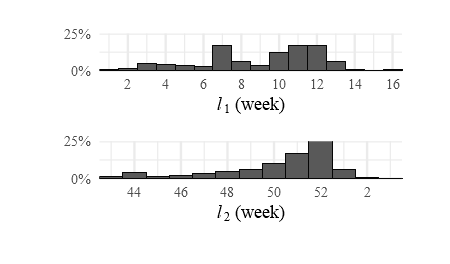

In [242]:
cs = c(3.75,2.2)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

pltt = "Greys"

brks = seq(0,52,2)
shift = 26
l1lmts = c(43,56); l1lmts=(l1lmts-shift-1)%%52+1 
l2lmts = c(1,17); 
zmax = .25

p1 = Samples %>% 
    mutate(l1=(l1-shift-1)%%52+1) %>%
    ggplot(aes(l1)) + 
    geom_histogram(center=0.5, binwidth=1, closed='left',
                   aes(y = (..count..)/sum(..count..)),color="black",size=.2) +
    coord_cartesian(expand=0,xlim=c(l1lmts[1],l1lmts[2]),ylim=c(0,zmax)) +
    scale_x_continuous(breaks = brks+.5, labels = (brks+shift-1)%%52+1) +
    scale_y_continuous(breaks = c(0,zmax),labels = round(c(0, zmax)*100,0)%&%"%") +
    theme_minimal(base_size=11,base_family='Times') +
    labs(x=expression(italic(l)[2]*" (week)"),y="") +
    theme(legend.title=element_text(size=8),
          legend.text=element_text(angle=0,size=7),
          plot.margin=unit(c(.5,2,.5,1.85),"lines"))

p2 = Samples %>% 
    ggplot(aes(l2)) + 
    geom_histogram(center=0.5, binwidth=1, closed='left',
                   aes(y = (..count..)/sum(..count..)),color="black",size=.2) + 
    guides(fill=FALSE) +
    scale_fill_distiller(palette = pltt,limits = c(0,zmax)) +
    coord_cartesian(expand=0,xlim=c(l2lmts[1],l2lmts[2]),ylim=c(0,zmax)) +
    scale_x_continuous(breaks = brks+.5, labels = brks) +
    scale_y_continuous(breaks = c(0,zmax),labels = round(c(0, zmax)*100,0)%&%"%") +
    theme_minimal(base_size=11,base_family='Times') +
    labs(x=expression(italic(l)[1]*" (week)"),y="") +
    theme(plot.margin=unit(c(.5,2,.5,1.85),"lines"))

grid.arrange(rectGrob(gp=gpar(col=NA)),ggplotGrob(p2),ggplotGrob(p1),rectGrob(gp=gpar(col=NA)),
             heights=c(.2,1,1,.25), widths=c(1)) -> pTimeBoundaries

pTimeBoundaries = arrangeGrob(pTimeBoundaries, top = textGrob(expression((italic(b))), x = unit(0, "npc"), y = unit(.5, "npc"), just=c("left","top"),
         gp=gpar(col="black", fontsize=9, fontface="italic", fontfamily="Times")))

Warning message:
"Removed 4 rows containing missing values (geom_point)."Warning message:
"Removed 10 rows containing missing values (geom_point)."Warning message:
"Removed 3 rows containing missing values (geom_point)."

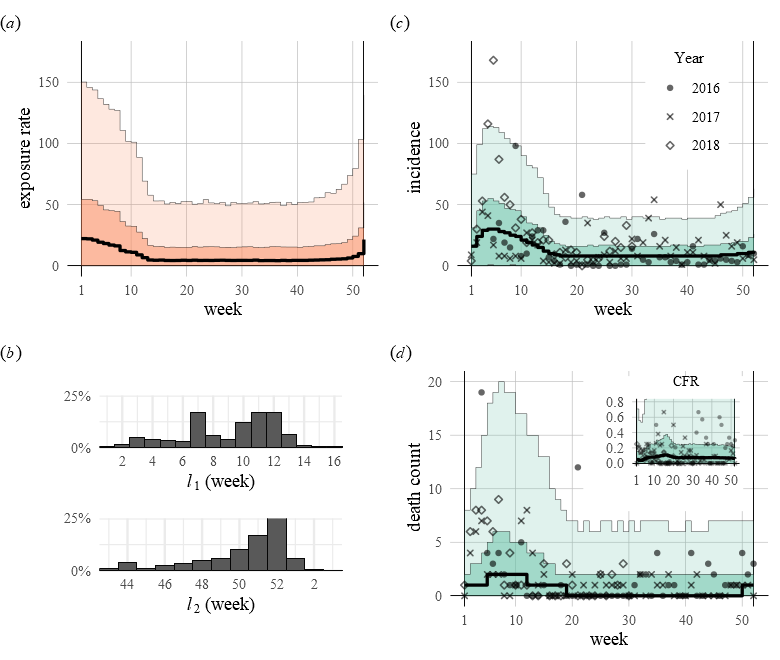

In [243]:
cs = c(6.5,5.5)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

pchs = c(16,4,5)

alphaNarrow = 0.5
alphaWide = 0.2
clr = c("#fc8d62","#66c2a5") %>% rev

resultMCMCtotal %>%
    filter(Var=="incidence") %>%
    ggplot(aes(x=Week)) +
        geom_hline(yintercept=0,size=.2,color="black") +
        geom_vline(xintercept=1,size=.2,color="black") +
        geom_vline(xintercept=52,size=.2,color="black") +
        # exposure
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=lowerNarrow, ymax=upperNarrow),fill=clr[1],alpha=alphaNarrow) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=lowerWide, ymax=upperWide),fill=clr[1],alpha=alphaWide) +
        geom_step(aes(y=lowerWide),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=upperWide),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=lowerNarrow),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=upperNarrow),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=median),size=.7,color="black") +
        # data
        geom_point(data=Df %>% filter(Year>=yearMin) %>% mutate(Year=Year %>% as.character),
                   aes(y=Incidence_Reported,pch=Year),size=1.2,alpha=.6) +
        # layout
        coord_cartesian(ylim=c(0,175)) +
        scale_shape_manual(values=pchs) +
        guides(shape=guide_legend(ncol = 1, title = "Year", title.hjust=.55)) +
        expand_limits(x = 1, y = 0) +
        scale_x_continuous("week",breaks = c(1,seq(10,52,10))) +
        scale_y_continuous("incidence") +
        theme_minimal(base_size=11,base_family='Times') +
        theme(legend.position = c(0.74, 0.73),
              legend.background = element_rect(colour = "white"),
              legend.text=element_text(size=8),
              legend.title=element_text(size=9),
              panel.grid.major = element_line(colour = "grey",size=.15),
              panel.grid.minor = element_blank(),
              plot.margin = unit(c(.5,.5,.5,.75),"lines")) -> pIncidence

pIncidence = arrangeGrob(pIncidence, top = textGrob(expression((italic(c))), x = unit(0, "npc"), y = unit(.5, "npc"), just=c("left","top"),
         gp=gpar(col="black", fontsize=9, fontface="italic", fontfamily="Times")))

resultMCMCtotal %>%
    filter(Var=="deaths") %>%
    ggplot(aes(x=Week)) +
        geom_hline(yintercept=0,size=.2,color="black") +
        geom_vline(xintercept=1,size=.2,color="black") +
        geom_vline(xintercept=52,size=.2,color="black") +
        # exposure
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=lowerNarrow, ymax=upperNarrow),fill=clr[1],alpha=alphaNarrow) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=lowerWide, ymax=upperWide),fill=clr[1],alpha=alphaWide) +
        geom_step(aes(y=lowerWide),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=upperWide),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=lowerNarrow),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=upperNarrow),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=median),size=.7,color="black") +
        # data
        geom_point(data=Df %>% filter(Year>=yearMin) %>% mutate(Year=Year %>% as.character),
                   aes(y=Incidence_Deaths,pch=Year),size=1.2,alpha=.6) +
        # layout
        scale_shape_manual(values=pchs) +
        guides(shape=FALSE) +
        expand_limits(x = 1, y = 0) +
        scale_x_continuous("week",breaks = c(1,seq(10,52,10))) +
        scale_y_continuous("death count") +
        theme_minimal(base_size=11,base_family='Times') +
        theme(
              panel.grid.major = element_line(colour = "grey",size=.15),
              panel.grid.minor = element_blank(),
              plot.margin = unit(c(.5,.5,.5,.75),"lines")) -> pDeaths

resultMCMCtotal %>%
    filter(Var=="CFR") %>%
    ggplot(aes(x=Week)) +
        geom_hline(yintercept=0,size=.2,color="black") +
        geom_vline(xintercept=1,size=.2,color="black") +
        geom_vline(xintercept=52,size=.2,color="black") +
        # exposure
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=lowerNarrow, ymax=upperNarrow),fill=clr[1],alpha=alphaNarrow) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=lowerWide, ymax=upperWide),fill=clr[1],alpha=alphaWide) +
        geom_step(aes(y=lowerWide),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=upperWide),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=lowerNarrow),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=upperNarrow),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=median),size=.7,color="black") +
        # data
        geom_point(data=Df %>% filter(Year>=yearMin) %>% 
                       mutate(Year=Year %>% as.character, CFR=Incidence_Deaths/Incidence_Reported),
                   aes(y=CFR,pch=Year),size=.6,alpha=.4) +
        # layout
        scale_shape_manual(values=pchs) +
        guides(shape=FALSE) +
        ggtitle("CFR") +
        expand_limits(x = 1, y = 0) +
        scale_x_continuous("",breaks = c(1,seq(10,52,10))) +
        scale_y_continuous("") +
        coord_cartesian(ylim=c(0,0.8)) +
        theme_minimal(base_size=11,base_family='Times') +
        theme(plot.title = element_text(size=8,hjust = 0.5),
              panel.grid.major = element_line(colour = "grey",size=.15),
              panel.grid.minor = element_blank(),
              plot.margin = unit(c(0,.1,.1,.1),"lines")) -> pCFR

resultMCMCtotal %>%
    filter(Var=="exposure") %>%
    ggplot(aes(x=Week)) +
        geom_hline(yintercept=0,size=.2,color="black") +
        geom_vline(xintercept=1,size=.2,color="black") +
        geom_vline(xintercept=52,size=.2,color="black") +
        # exposure
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=lowerNarrow, ymax=upperNarrow),fill=clr[2],alpha=alphaNarrow) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=lowerWide, ymax=upperWide),fill=clr[2],alpha=alphaWide) +
        geom_step(aes(y=lowerWide),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=upperWide),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=lowerNarrow),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=upperNarrow),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=median),size=.7,color="black") +
        # layout
        coord_cartesian(ylim=c(0,175)) +
        scale_shape_manual(values=pchs) +
        guides(shape=guide_legend(ncol = 1, title = "Year", title.hjust=.55)) +
        expand_limits(x = 1, y = 0) +
        scale_x_continuous("week",breaks = c(1,seq(10,52,10))) +
        scale_y_continuous("exposure rate") +
        theme_minimal(base_size=11,base_family='Times') +
        theme(legend.position = c(0.74, 0.73),
              legend.background = element_rect(colour = "grey"),
              legend.text = element_text(),
              panel.grid.major = element_line(colour = "grey",size=.15),
              panel.grid.minor = element_blank(),
              plot.margin = unit(c(.5,.5,.5,.75),"lines")) -> pExposure

pExposure = arrangeGrob(pExposure, top = textGrob(expression((italic(a))), x = unit(0, "npc"), y = unit(.5, "npc"), just=c("left","top"),
         gp=gpar(col="black", fontsize=9, fontface="italic", fontfamily="Times")))

pDeaths = pDeaths + annotation_custom(grob = ggplotGrob(pCFR+theme(plot.background = element_rect(colour = "white"))), 
                       xmin = 22, xmax = 50, ymin = 8, ymax = 20.5)

pDeaths = arrangeGrob(pDeaths, top = textGrob(expression((italic(d))), x = unit(0, "npc"), y = unit(.5, "npc"), just=c("left","top"),
         gp=gpar(col="black", fontsize=9, fontface="italic", fontfamily="Times")))

pFinal = grid.arrange(pExposure, pIncidence, pTimeBoundaries, pDeaths, widths=c(1,1), heights=c(1,1), nrow=2, ncol=2)

ggsave(plot=pFinal,width=cs[1],height=cs[2],filename="../figures/Fig1.pdf", useDingbats=FALSE)

# Some part about transmission of LF among rodents

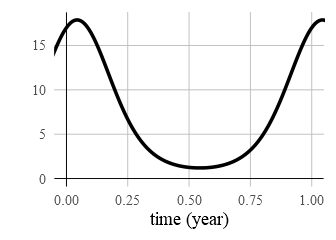

In [244]:
cs = c(2.8,2)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

data.frame(t=seq(-1,2,length.out=600),s=2.7,phi=.42+pi*.41-pi/2,kappa=17.879) %>% 
    mutate(B=kappa*exp(-s*(sin(pi*t-phi))^2)) %>% 
    ggplot(aes(x=t)) +
    geom_hline(yintercept=0,size=.2,color="black") + 
    geom_vline(xintercept=0,size=.2,color="black") +
    geom_path(aes(y=B),size=.75,color="black") +
    theme_minimal(base_size=11,base_family='Times') + 
    labs(x=expression(italic(x)),y=NULL) + 
    coord_cartesian(xlim=c(0,1)) +
    labs(x="time (year)",y="") +
    theme(plot.margin = unit(c(.5,.5,.5,.5),"lines"),
          panel.grid.major = element_line(colour = "grey",size=.2),
          panel.grid.minor = element_blank()) -> p
p

ggsave(plot=p,width=cs[1],height=cs[2],filename="../figures/draft/birth_pulse.pdf", useDingbats=FALSE)

In [111]:
# Change in population of rodent per week
dfRodents = data.frame(Week = 1:52, 
                       Rodents = c(5.87587495463,6.5626881195,7.47803230221,8.69394373744,10.3292096722,12.4343933085,15.026196806,18.2218623932,
                                   22.0691380378,26.7038731186,31.966711592,37.5742983399,43.4454895516,49.308101405,54.9821510205,59.9699611104,
                                   63.8579572712,66.5609247319,67.9586146603,67.9540997054,66.6637133988,64.272741448,60.9974520691,56.9668880357,
                                   52.5182421675,47.9964174994,43.470459102,39.0772433639,34.8099451503,30.8500725999,27.3259683757,24.142175645,
                                   21.2945665599,18.7075468051,16.4336620247,14.4979101018,12.8111787955,11.313423624,10.0238289295,8.94763471548,
                                   8.02893017022,7.25072812588,6.58349913082,6.03515487487,
                                   5.60712284844,5.27677308106,5.04025128919,4.89466553097,4.84913365821,4.90937465989,5.08455169687,5.39289622053))
dfRodents %<>% gather(Category,Value,-Week) %>%
    mutate(anum = if_else(Week>=samplesSummary$l1[['Median']]&Week<=samplesSummary$l2[['Median']],2,1))
dfRodents %>% head

Week,Category,Value,anum
1,Rodents,5.875875,1
2,Rodents,6.562688,1
3,Rodents,7.478032,1
4,Rodents,8.693944,1
5,Rodents,10.329210,1
6,Rodents,12.434393,1


In [112]:
resultRodents = data.frame(Week=dfRodents$Week,
                       lowerWide=filter(resultMCMCtotal,Var=="exposure")$lowerWide/dfRodents$Value,
                       lowerNarrow=filter(resultMCMCtotal,Var=="exposure")$lowerNarrow/dfRodents$Value,
                       median=filter(resultMCMCtotal,Var=="exposure")$median/dfRodents$Value,
                       upperNarrow=filter(resultMCMCtotal,Var=="exposure")$upperNarrow/dfRodents$Value,
                       upperWide=filter(resultMCMCtotal,Var=="exposure")$upperWide/dfRodents$Value,
                       mean=filter(resultMCMCtotal,Var=="exposure")$mean/dfRodents$Value) 

resultRodents %<>% as.data.frame
resultRodents %>% head

Week,lowerWide,lowerNarrow,median,upperNarrow,upperWide,mean
1,7.339577e-07,7.339577e-07,3.636359,8.728890,24.00303,6.708191
2,1.941212e-07,1.941212e-07,3.449089,8.265415,22.53047,6.397029
3,3.971687e-06,3.971687e-06,2.873629,7.469586,20.24742,5.695043
4,5.800401e-10,5.800401e-10,2.098374,5.493357,14.95968,4.225928
5,4.813025e-07,4.813025e-07,1.643661,4.536654,13.03294,3.412741
6,7.079729e-10,7.079729e-10,1.429442,3.868949,10.28622,2.923314


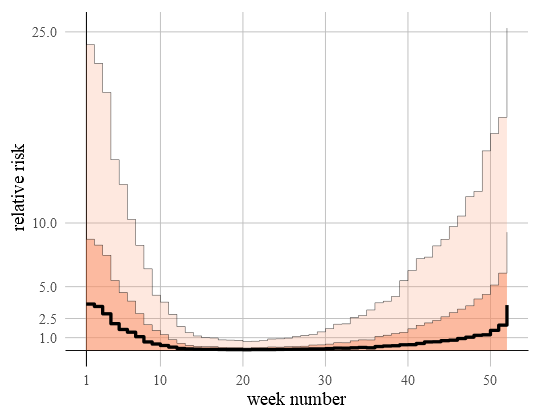

In [113]:
cs = c(4.5,3.5)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

p = resultRodents %>% 
    ggplot(aes(x=Week)) +
        geom_hline(yintercept=0,size=.2,color="black") +
        geom_vline(xintercept=1,size=.2,color="black") +
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=lowerNarrow, ymax=upperNarrow),fill=clr[2],alpha=alphaNarrow) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=lowerWide, ymax=upperWide),fill=clr[2],alpha=alphaWide) +
        geom_step(aes(y=lowerWide),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=upperWide),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=lowerNarrow),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=upperNarrow),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=median),size=.7,color="black") +
        scale_x_continuous(breaks = c(1,seq(10,52,10))) +
        scale_y_continuous(breaks = c(1,2.5,5,10,25,50,100)) +
        labs(x="week number",y="relative risk") +
        theme_minimal(base_size=11,base_family='Times') +
        theme(legend.text = element_text(),
              panel.grid.major = element_line(colour = "grey",size=.2),
              panel.grid.minor = element_blank(),
              plot.margin = unit(c(.5,.5,.5,.5),"lines"))
p

In [114]:
filter(resultMCMC0,Category=="l1")$median

[1] 50.82328

In [115]:
filter(resultMCMC0,Category=="l2")$median

[1] 10.22321

In [116]:
# now we adjust the risk so that the average over the low-risk period would be equal one
l1median = filter(resultMCMC0,Category=="l2")$median
l2median = filter(resultMCMC0,Category=="l1")$median
resultRodents %>% 
    filter((Week>=l1median)&(Week<=l2median)) %>%
    .$median %>% mean -> kappa
kappa

[1] 0.3562024

In [117]:
resultRodents %>% mutate_each(funs(./kappa),-Week) -> resultRodents_Adjusted

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


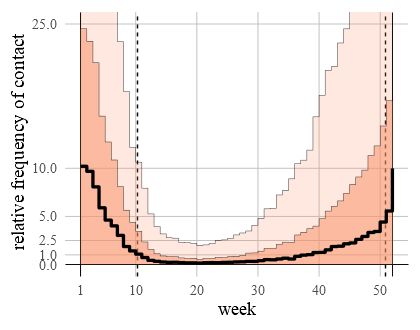

In [118]:
cs = c(3.5,2.75)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

resultRodents_Adjusted %>% 
    ggplot(aes(x=Week)) +
        geom_hline(yintercept=0,size=.2,color="black") +
        geom_vline(xintercept=1,size=.2,color="black") +
        geom_vline(xintercept=52,size=.2,color="black") +
        geom_vline(xintercept=l1median,size=.3,color="black",linetype=2) +
        geom_vline(xintercept=l2median,size=.3,color="black",linetype=2) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=lowerNarrow, ymax=upperNarrow),fill=clr[2],alpha=alphaNarrow) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=lowerWide, ymax=upperWide),fill=clr[2],alpha=alphaWide) +
        geom_step(aes(y=lowerWide),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=upperWide),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=lowerNarrow),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=upperNarrow),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=median),size=.7,color="black") +
        coord_cartesian(ylim=c(0,25)) +
        scale_x_continuous(breaks = c(1,seq(10,52,10))) +
        scale_y_continuous(breaks = c(0,1,2.5,5,10,25,50,100)) +
        labs(x="week",y="relative frequency of contact") +
        theme_minimal(base_size=11,base_family='Times') +
        theme(legend.text = element_text(),
              panel.grid.major = element_line(colour = "grey",size=.2),
              panel.grid.minor = element_blank(),
              plot.margin = unit(c(.5,.5,.5,.5),"lines")) -> p

p

ggsave(plot=p,width=cs[1],height=cs[2],filename="../figures/Fig3.pdf", useDingbats=FALSE)

In [119]:
resultRodents_Adjusted %>% head

Week,lowerWide,lowerNarrow,median,upperNarrow,upperWide,mean
1,2.060508e-06,2.060508e-06,10.208689,24.50542,67.38593,18.832528
2,5.449745e-07,5.449745e-07,9.682946,23.20426,63.25188,17.958971
3,1.115008e-05,1.115008e-05,8.067405,20.97006,56.84246,15.988221
4,1.628400e-09,1.628400e-09,5.890961,15.42201,41.99769,11.863841
5,1.351205e-06,1.351205e-06,4.614401,12.73617,36.58859,9.580905
6,1.987558e-09,1.987558e-09,4.013004,10.86166,28.87745,8.206892


In [120]:
resultRodents_Adjusted %>%
    filter((Week<l1median)|(Week>l2median)) %>%
    .$median %>% mean

[1] 5.450912

# Loading the data

In [139]:
yearMin = 2016

data = read_excel("../data/Nigeria_raw.xlsx", sheet = "Incidence") %>%
    select(-one_of("Timeseries","Imputation","File in the repo"),-contains("URL")) %>%
    filter(Year>=yearMin) %>%
    group_by(Year) %>%
    mutate(Incidence_Reported = if_else(Week==1,Reported,Reported-lead(Reported)), 
           Incidence_Deaths = if_else(Week==1,Deaths,Deaths-lead(Deaths))
          ) %>%
    ungroup

data %>% tail

Year,Week,LGAs,States,Reported,Deaths,Confirmed,Positive_Incidence,Negative_Incidence,Incidence_Reported,Incidence_Deaths
2016,6,93,24,377,60,35,NA,NA,35,3
2016,5,83,23,342,57,32,NA,NA,22,4
2016,4,NA,NA,320,53,NA,NA,NA,NA,19
2016,3,NA,NA,NA,34,NA,NA,NA,NA,NA
2016,2,NA,NA,NA,NA,NA,NA,NA,NA,NA
2016,1,NA,NA,NA,NA,NA,NA,NA,NA,NA


# Analysis using MLE

In [60]:
data %>% 
    select(-LGAs,-States) %>%
    arrange(Year,Week) -> df

df %>% head

Year,Week,Reported,Deaths,Confirmed,Positive_Incidence,Negative_Incidence,Incidence_Reported,Incidence_Deaths
2016,1,NA,NA,NA,NA,NA,NA,NA
2016,2,NA,NA,NA,NA,NA,NA,NA
2016,3,NA,34,NA,NA,NA,NA,NA
2016,4,320,53,NA,NA,NA,NA,19
2016,5,342,57,32,NA,NA,22,4
2016,6,377,60,35,NA,NA,35,3


In [61]:
rho = 0.19
getLogLk = function(prms,indices,Df=filter(df,Year>=yearMin)) {
    indexExposureLower = indices[1] 
    indexExposureUpper = indices[2]
    
    exposure = prms[1:2]
    riskOfDeath = prms[3]
    
    # Incubation period = gamma distribution
    incubation_shape = mediansJos$incubation_mean^2/mediansJos$incubation_var
    incubation_rate = mediansJos$incubation_mean/mediansJos$incubation_var*7.0 #from days to weeks
    # Time from Onset to Death
    death_shape = mediansJos$death_mean^2/mediansJos$death_var
    death_rate = mediansJos$death_mean/mediansJos$death_var*7.0 #from days to weeks    
    
    # Convolution
    ## in order to nulify the boundary conditions for convolution, we determine a stabilized structure
    ## the program also assumes that there were 52 weeks for each year
    data.frame(Year=yearMin-1,Week=1:52) %>%
    rbind(data.frame(Year=df$Year,Week=df$Week)) %>% 
        mutate(exposureNum = if_else(Week>=indexExposureLower & Week<=indexExposureUpper,2,1)) -> dfTmp
    
    incubation_probability = pgamma(1:nrow(dfTmp),shape=incubation_shape,rate=incubation_rate)-
        pgamma(1:nrow(dfTmp)-1,shape=incubation_shape,rate=incubation_rate)
    timeFromOnsetToDeath_probability = pgamma(1:nrow(dfTmp),shape=death_shape,rate=death_rate)-
        pgamma(1:nrow(dfTmp)-1,shape=death_shape,rate=death_rate)
    # time from Exposure event to Death is the convolution of two latter probabilities
    timeFromExposureToDeath_probability = c(0)
    for (x in 2:nrow(dfTmp)) {
        timeFromExposureToDeath_probability = c(timeFromExposureToDeath_probability,
            sum(incubation_probability[1:(x-1)]*timeFromOnsetToDeath_probability[(x-1):1]))
    }
    convExposure = c(0)
    convDeath = c(0)
    for (x in 2:nrow(dfTmp)) {
        convExposure = c(convExposure,sum(exposure[dfTmp$exposureNum[(x-1):1]]*incubation_probability[1:(x-1)]))
        convDeath = c(convDeath,sum(exposure[dfTmp$exposureNum[(x-1):1]]*timeFromExposureToDeath_probability[1:(x-1)]))
    }
    cbind(dfTmp,convExposure=convExposure,convDeath=convDeath) %>% 
        select(Year,Week,contains("conv"),contains("Num")) %>%
        left_join(Df,by=c("Year","Week")) -> dfTmp
        
    dfTmp %<>%
        mutate(lambdaReported = convExposure/(1-rho), 
               lambdaDeath = riskOfDeath*convDeath/(1-rho))
    # First likelihood is about incidence in reported cases (positive+negative+pending)    
    dfTmp %>% 
        filter(!is.na(Incidence_Reported)) %>%
        summarize(loglk = sum(Incidence_Reported*log(lambdaReported)-lambdaReported)) %>% .$loglk -> loglkReported 
    # Second likelihood is about risk of death
    dfTmp %>%
        filter(!is.na(Incidence_Deaths)) %>%
        summarize(loglk = sum(Incidence_Deaths*log(lambdaDeath)-lambdaDeath)) %>% .$loglk -> loglkDeaths
    loglkReported + loglkDeaths %>% return 
}

#for Bhat::dfp
getNegativeLogLk = function(x) { -getLogLk(x) } 

initParams = c(30,20,.1)
indexes = c(4,50,9,33)
result = getLogLk(initParams,indexes)
result

[1] 4016.397

In [62]:
# Finding MLE numerically
# options(warn=-1)
(sol = optim(initParams,
             function(x) getLogLk(x,indexes),
             method="L-BFGS-B",
             lower=rep(1e-18,length(initParams)),
             upper=c(Inf,Inf,1,1),
             control=list(fnscale=-1)))
# options(warn=0)
sol$par

$par
[1] 46.1567886 11.0174124  0.0931207

$value
[1] 4432.885

$counts
function gradient 
      24       24 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

[1] 46.1567886 11.0174124  0.0931207

## Then I use Julia to do global search for maximal likelihood. *R* is too slow.

The results of simulations were stored in MLEsearch-XX.csv files. First, I scan them.

In [63]:
filename = paste0("./MLE/MLEsearch.csv")
if (file.exists(filename)) {
    read.table(file=filename,header=TRUE,sep=",") %>% 
        unique -> result
}
result %<>% arrange(loglk) 
result %>% head(5)

i1,i2,exp1,exp2,CFR,loglk
8,51,36.860533,9.609034,0.09508309,-4528.662
7,51,39.577341,9.895129,0.09476728,-4511.523
9,51,34.170637,9.454936,0.09540644,-4508.527
1,7,9.865068,38.221185,0.09613383,-4503.657
10,51,32.219099,9.252237,0.09563705,-4496.131


### Best result

In [64]:
initParams = c(40,12,.05)
(solMLE = optim(initParams,
             function(x) getLogLk(x,as.numeric(result[1,1:2])),
             method="L-BFGS-B",
             lower=rep(1e-18,length(initParams)),
             upper=c(Inf,Inf,1,1),
             control=list(fnscale=-1),
             hessian=TRUE))

-0.7545543,-0.137831,-29.42159
-0.1378310,-14.741772,-132.30680
-29.4215929,-132.306802,-24780.18118


# Using Hessian

Sampling using Hessian

In [65]:
nsmpl = 1e3
hess_sam = MASS::mvrnorm(n=nsmpl, mu=solMLE$par, 
                     Sigma=solve(-solMLE$hessian),
                     tol=1e-06, empirical=FALSE, EISPACK=FALSE)
hess_sam %>% as.data.frame -> df_hess

clmn_nms = c("aPlus","aMinus","q")
colnames(df_hess) = clmn_nms
df_hess %>% head

aPlus,aMinus,q
35.19113,9.494415,0.09282822
38.17825,9.936446,0.08782262
38.21300,9.416081,0.09098536
34.91080,9.737098,0.10692049
35.68503,9.508391,0.09321519
38.03075,9.558511,0.09572717


In [66]:
data.frame(
    aPlus=filter(df_hess,aPlus > quantile(aPlus, 0.025) & aPlus < quantile(aPlus, 0.975))$aPlus,
    aMinus=filter(df_hess,aMinus > quantile(aMinus, 0.025) & aMinus < quantile(aMinus, 0.975))$aMinus,
    q=filter(df_hess,q > quantile(q, 0.025) & q < quantile(q, 0.975))$q
) -> df_perturb

df_perturb %>% head

aPlus,aMinus,q
35.19113,9.494415,0.09282822
38.17825,9.936446,0.08782262
38.21300,9.416081,0.09098536
34.91080,9.737098,0.10692049
35.68503,9.508391,0.09321519
38.03075,9.558511,0.09572717


# Likelihood profile based confidence intervals

In [67]:
chi2value = 3.84/2 #95% CIs

df_ = filter(df,Year>=yearMin)

## First, for indexes like $l_{1,2}$

In [68]:
result %>% head

i1,i2,exp1,exp2,CFR,loglk
8,51,36.860533,9.609034,0.09508309,-4528.662
7,51,39.577341,9.895129,0.09476728,-4511.523
9,51,34.170637,9.454936,0.09540644,-4508.527
1,7,9.865068,38.221185,0.09613383,-4503.657
10,51,32.219099,9.252237,0.09563705,-4496.131
5,51,46.997363,10.630804,0.09391365,-4495.330


In [69]:
result %>% 
    group_by(i2) %>%
    filter(loglk==min(loglk)) %>% 
    ungroup %>%
    filter(loglk<=min(loglk)+chi2value)

i1,i2,exp1,exp2,CFR,loglk
8,51,36.86053,9.609034,0.09508309,-4528.662


In [70]:
df_perturb %<>% 
    mutate(i1 = runif(nrow(df_perturb),result[1,1],result[1,1]+1) %>% floor, 
           i2 = runif(nrow(df_perturb),result[1,2],result[1,2]+1) %>% floor)

df_perturb %>% head

aPlus,aMinus,q,i1,i2
35.19113,9.494415,0.09282822,8,51
38.17825,9.936446,0.08782262,8,51
38.21300,9.416081,0.09098536,8,51
34.91080,9.737098,0.10692049,8,51
35.68503,9.508391,0.09321519,8,51
38.03075,9.558511,0.09572717,8,51


## For aPlus

x,loglk
35.19113,4527.628
38.17825,4528.052
38.21300,4528.019
34.91080,4527.244
35.68503,4528.154
38.03075,4528.179


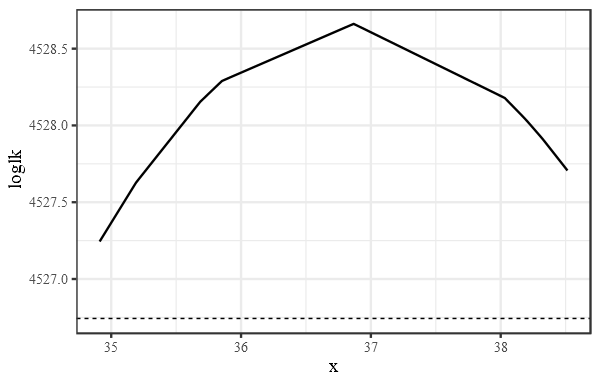

In [71]:
loglks = c()
var = df_hess$aPlus[1:10]
getLogLk_with_fixed_aPlus = function(x) getLogLk(c(value,x),as.numeric(result[1,1:2]),df_)
for (jj in 1:length(var)) {
    value = var[[jj]]
    if (value>0) {
        options(warn=-1)
        sol = optim(as.numeric(df_hess[jj,2:3]),getLogLk_with_fixed_aPlus,method="BFGS",
                       control=list(fnscale=-1),hessian=FALSE)
        options(warn=0)
        loglks = c(loglks,sol$value) }
    else {
        loglks = c(loglks,NA) }
}
df_perturb0 = data.frame(x=var,loglk=loglks)
(df_perturb0 %>% head)

options(repr.plot.width=5,repr.plot.height=3.2)

df_perturb0 %>% 
    ggplot(aes(x=x,y=loglk)) +
        geom_line() +
        geom_hline(yintercept = solMLE$value-chi2value,size=.3,linetype="dashed")

In [72]:
getboundary = function(value) { 
    solMLE$value-optim(solMLE$par[2:3],
                       function(x) getLogLk(c(value,x),as.numeric(result[1,1:2]),df_),
                       method="BFGS",control=list(fnscale=-1),hessian=FALSE)$value-chi2value }
options(warn=-1)
(xleft = tryCatch(uniroot(getboundary, c(10,solMLE$par[1]))$root,error=function(cond){cond}))
(xright = tryCatch(uniroot(getboundary, c(solMLE$par[1],200))$root,error=function(cond){cond}))
options(warn=0)

[1] 34.5984

[1] 39.21903

In [73]:
resultFit = data.frame(variable="exposureHigh",MLE=solMLE$par[1],CILower=xleft,CIUpper=xright)
resultFit

variable,MLE,CILower,CIUpper
exposureHigh,36.86046,34.5984,39.21903


## For aMinus

x,loglk
9.494415,4528.569
9.936446,4527.926
9.416081,4528.397
9.737098,4528.548
9.508391,4528.590
9.558511,4528.644


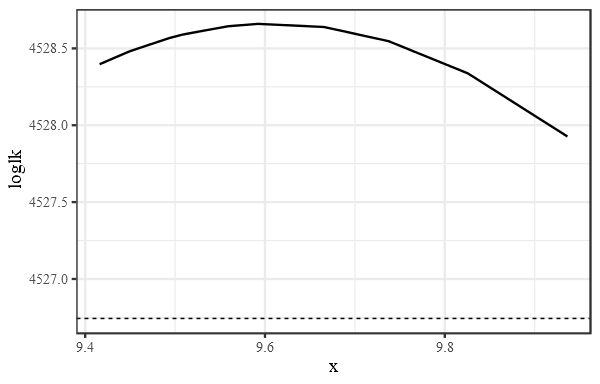

In [74]:
loglks = c()
var = df_hess$aMinus[1:10]
getLogLk_with_fixed_aMinus = function(x) getLogLk(c(x[1],value,x[2]),as.numeric(result[1,1:2]),df_)
for (jj in 1:length(var)) {
    value = var[[jj]]
    if (value>0) {
        options(warn=-1)
        sol = optim(as.numeric(df_hess[jj,-2]),getLogLk_with_fixed_aMinus,method="BFGS",
                       control=list(fnscale=-1),hessian=FALSE)
        options(warn=0)
        loglks = c(loglks,sol$value) }
    else {
        loglks = c(loglks,NA) }
}
df_perturb0 = data.frame(x=var,loglk=loglks)
(df_perturb0 %>% head)

options(repr.plot.width=5,repr.plot.height=3.2)

df_perturb0 %>% 
    ggplot(aes(x=x,y=loglk)) +
        geom_line() +
        geom_hline(yintercept = solMLE$value-chi2value,size=.3,linetype="dashed")

In [75]:
getboundary = function(value) { 
    solMLE$value-optim(solMLE$par[-2],
                       function(x) getLogLk(c(x[1],value,x[2]),as.numeric(result[1,1:2]),df_),
                       method="BFGS",control=list(fnscale=-1),hessian=FALSE)$value-chi2value }
options(warn=-1)
(xleft = tryCatch(uniroot(getboundary, c(.5*solMLE$par[2],solMLE$par[2]))$root,error=function(cond){cond}))
(xright = tryCatch(uniroot(getboundary, c(solMLE$par[2],1.25*solMLE$par[2]))$root,error=function(cond){cond}))
options(warn=0)

[1] 9.095494

[1] 10.14173

In [76]:
resultFit %<>% rbind(data.frame(variable="exposureLow",MLE=solMLE$par[2],CILower=xleft,CIUpper=xright))
resultFit

variable,MLE,CILower,CIUpper
exposureHigh,36.860462,34.598397,39.21903
exposureLow,9.609014,9.095494,10.14173


## For CFR (q)

x,loglk
0.09282822,4528.603
0.08782262,4528.033
0.09098536,4528.466
0.10692049,4527.214
0.09321519,4528.622
0.09572717,4528.657


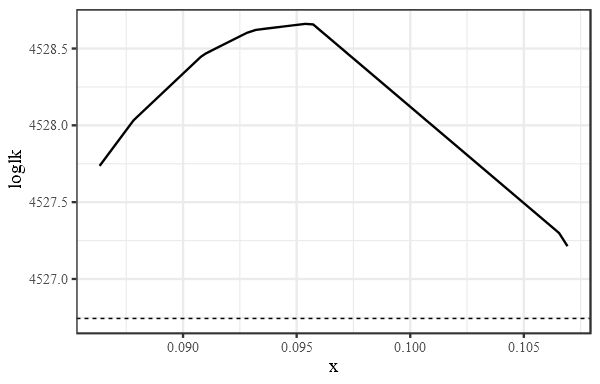

In [77]:
loglks = c()
var = df_hess$q[1:10]
getLogLk_with_fixed_pMinus = function(x) getLogLk(c(x[1:2],value),as.numeric(result[1,1:2]),df_)
for (jj in 1:length(var)) {
    value = var[[jj]]
    if (value>0) {
        options(warn=-1)
        sol = optim(as.numeric(df_hess[jj,-3]),getLogLk_with_fixed_pMinus,method="BFGS",
                       control=list(fnscale=-1),hessian=FALSE)
        options(warn=0)
        loglks = c(loglks,sol$value) }
    else {
        loglks = c(loglks,NA) }
}
df_perturb0 = data.frame(x=var,loglk=loglks)
(df_perturb0 %>% head)

options(repr.plot.width=5,repr.plot.height=3.2)

df_perturb0 %>% 
    ggplot(aes(x=x,y=loglk)) +
        geom_line() +
        geom_hline(yintercept = solMLE$value-chi2value,size=.3,linetype="dashed")

In [78]:
getboundary = function(value) { 
    solMLE$value-optim(solMLE$par[-4],
                       function(x) getLogLk(c(x[1:2],value),as.numeric(result[1,1:2]),df_),
                       method="BFGS",control=list(fnscale=-1),hessian=FALSE)$value-chi2value }
options(warn=-1)
(xleft = tryCatch(uniroot(getboundary, c(.01,solMLE$par[3]))$root,error=function(cond){cond}))
(xright = tryCatch(uniroot(getboundary, c(solMLE$par[3],.15))$root,error=function(cond){cond}))
options(warn=0)

[1] 0.08268855

[1] 0.1087738

In [79]:
resultFit %<>% rbind(data.frame(variable="CFR",MLE=solMLE$par[3],CILower=xleft,CIUpper=xright))

## Final result of the MLE fit

In [80]:
resultFit

variable,MLE,CILower,CIUpper
exposureHigh,36.86046228,34.59839689,39.2190313
exposureLow,9.60901425,9.09549382,10.1417332
CFR,0.09508671,0.08268855,0.1087738


In [81]:
data.frame(Week=1:52) %>% 
    mutate(a = if_else(Week>=result[1,"i1"]&Week<=result[1,"i2"],
                       filter(resultFit,variable=="exposureLow")["MLE"] %>% as.numeric,
                       filter(resultFit,variable=="exposureHigh")["MLE"] %>% as.numeric),
           aCILower = if_else(Week>=result[1,"i1"]&Week<=result[1,"i2"],
                       filter(resultFit,variable=="exposureLow")["CILower"] %>% as.numeric,
                       filter(resultFit,variable=="exposureHigh")["CILower"] %>% as.numeric),
           aCIUpper = if_else(Week>=result[1,"i1"]&Week<=result[1,"i2"],
                       filter(resultFit,variable=="exposureLow")["CIUpper"] %>% as.numeric,
                       filter(resultFit,variable=="exposureHigh")["CIUpper"] %>% as.numeric)) -> df_fit

df_fit %>% head

Week,a,aCILower,aCIUpper
1,36.86046,34.5984,39.21903
2,36.86046,34.5984,39.21903
3,36.86046,34.5984,39.21903
4,36.86046,34.5984,39.21903
5,36.86046,34.5984,39.21903
6,36.86046,34.5984,39.21903


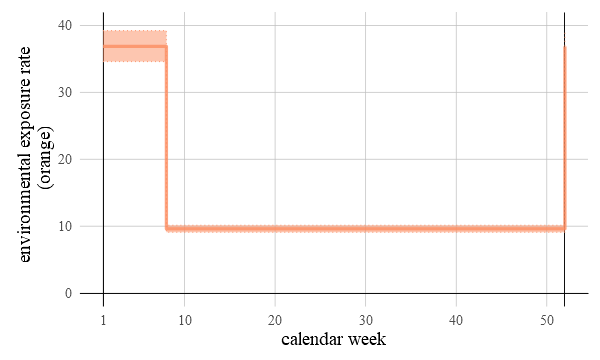

In [82]:
cs = c(5,3)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

alpha0 = 0.5
ymax = 40
clr = c("#fc8d62","#66c2a5")

df_fit %>%
    ggplot(aes(x=Week)) +
        geom_hline(yintercept=0,size=.2,color="black") +
        geom_vline(xintercept=1,size=.2,color="black") +
        geom_vline(xintercept=52,size=.2,color="black") +
        # exposure
        geom_step(aes(y=a),alpha=.8,size=.7,color=clr[1]) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=aCILower, ymax=aCIUpper),fill=clr[1],alpha=alpha0) +
        geom_step(aes(y=aCILower),alpha=.8,linetype=3,color=clr[1],size=.25) +
        geom_step(aes(y=aCIUpper),alpha=.8,linetype=3,color=clr[1],size=.25) +
        coord_cartesian(ylim=c(0,ymax)) + expand_limits(x = 1, y = 0) +
        scale_x_continuous("calendar week",breaks = c(1,seq(10,52,10))) +
        scale_y_continuous("environmental exposure rate\n(orange)") +
        guides(shape=FALSE,color=FALSE) +
        theme_minimal(base_size=11,base_family='Times') +
        theme(
              panel.grid.major = element_line(colour = "grey",size=.15),
              panel.grid.minor = element_blank(),
              plot.margin = unit(c(.5,.5,.5,.75),"lines"))

## First, I check that the previous figure is the same

In [83]:
data.frame(Week=1:52) %>% 
    mutate(a = if_else(Week>=result[1,"i1"]&Week<=result[1,"i2"],
                       solMLE$par[2],
                       solMLE$par[1]),
           aCILower = if_else(Week>=result[1,"i1"]&Week<=result[1,"i2"],
                       min(df_perturb$aMinus),
                       min(df_perturb$aPlus)),
           aCIUpper = if_else(Week>=result[1,"i1"]&Week<=result[1,"i2"],
                       max(df_perturb$aMinus),
                       max(df_perturb$aPlus))) -> df_fit2

df_fit2 %>% head

Week,a,aCILower,aCIUpper
1,36.86046,34.3624,39.08756
2,36.86046,34.3624,39.08756
3,36.86046,34.3624,39.08756
4,36.86046,34.3624,39.08756
5,36.86046,34.3624,39.08756
6,36.86046,34.3624,39.08756


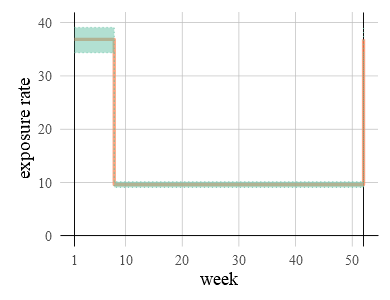

In [84]:
cs = c(3.25,2.5)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

alpha0 = 0.5

df_fit2 %>%
    ggplot(aes(x=Week)) +
        geom_hline(yintercept=0,size=.2,color="black") +
        geom_vline(xintercept=1,size=.2,color="black") +
        geom_vline(xintercept=52,size=.2,color="black") +
        # exposure
        geom_step(aes(y=a),alpha=.8,size=.7,color=clr[1]) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=aCILower, ymax=aCIUpper),fill=clr[2],alpha=alpha0) +
        geom_step(aes(y=aCILower),alpha=.8,linetype=3,color=clr[2],size=.25) +
        geom_step(aes(y=aCIUpper),alpha=.8,linetype=3,color=clr[2],size=.25) +
        coord_cartesian(ylim=c(0,ymax)) + expand_limits(x = 1, y = 0) +
        scale_x_continuous("week",breaks = c(1,seq(10,52,10))) +
        scale_y_continuous("exposure rate") +
        guides(shape=FALSE,color=FALSE) +
        theme_minimal(base_size=11,base_family='Times') +
        theme(
              panel.grid.major = element_line(colour = "grey",size=.15),
              panel.grid.minor = element_blank(),
              plot.margin = unit(c(.5,.5,.5,.75),"lines")) -> pExposureMLE

pExposureMLE

# Construction of uncertainty in trajectories

In [85]:
data.frame(Year=yearMin-1,Week=1:52) %>% rbind(df %>% select(Year,Week)) -> dfTrj

# Convolutions
incubation_probability = pgamma(1:nrow(dfTrj),shape=incubation_shape,rate=incubation_rate)-pgamma(1:nrow(dfTrj)-1,shape=incubation_shape,rate=incubation_rate)
timeFromOnsetToDeath_probability = pgamma(1:nrow(dfTrj),shape=death_shape,rate=death_rate)-pgamma(1:nrow(dfTrj)-1,shape=death_shape,rate=death_rate)
# time from Exposure event to Death is the convolution of two latter probabilities
timeFromExposureToDeath_probability = c(0)
for (x in 2:nrow(dfTrj)) {
    timeFromExposureToDeath_probability = c(timeFromExposureToDeath_probability,
        sum(incubation_probability[1:(x-1)]*timeFromOnsetToDeath_probability[(x-1):1]))
}

In [86]:
incidence = c()
deaths = c()

for (row_number in 1:nrow(df_perturb)) {
    rSmpl = df_perturb[row_number,] %>% as.list

    dfTrj %>% 
        mutate(exposure = if_else(Week>=rSmpl["i1"]&Week<=rSmpl["i2"],
                           rSmpl["aMinus"] %>% as.numeric,
                           rSmpl["aPlus"] %>% as.numeric),
               CFR = rSmpl["q"] %>% as.numeric) -> dfTmp_ 

    convExposure = c(0)
    convDeath = c(0)
    for (x in 2:nrow(dfTmp_)) {
        convExposure = c(convExposure,sum(dfTmp_$exposure[(x-1):1]*incubation_probability[1:(x-1)]))
        convDeath = c(convDeath,sum(dfTmp_$exposure[(x-1):1]*timeFromExposureToDeath_probability[1:(x-1)]))
    }
    dfTmp_ %<>% 
        cbind(convExposure=convExposure,convDeath=convDeath) %>% 
        mutate(incidence = convExposure/(1-rho), 
               deaths = CFR*convDeath/(1-rho)) 

    incidence = c(incidence,as.numeric(dfTmp_$incidence))
    deaths = c(deaths,as.numeric(dfTmp_$deaths))
}

matrix(incidence,nrow=nrow(dfTrj)) %>% 
    t %>% 
    as.data.frame %>%
    summarize_all(funs(min,max)) %>%
    matrix(ncol=2) -> df_

colnames(df_) = c("incidenceLower","incidenceUpper")

dfTrj %<>% cbind(df_)

matrix(deaths,nrow=nrow(dfTrj)) %>% 
    t %>% 
    as.data.frame %>%
    summarize_all(funs(min,max)) %>%
    matrix(ncol=2) -> df_

colnames(df_) = c("deathsLower","deathsUpper")

dfTrj %<>% cbind(df_)

dfTrj %>% head

Year,Week,incidenceLower,incidenceUpper,deathsLower,deathsUpper
2015,1,0,0,0,0
2015,2,3.439984,3.913016,0,0
2015,3,27.26557,31.01485,0.054514,0.07883161
2015,4,40.11008,45.6256,0.5467495,0.7906435
2015,5,42.22251,48.02851,1.617469,2.33899
2015,6,42.41052,48.24238,2.615781,3.782629


In [87]:
dfTrj %<>% 
    mutate(exposure = if_else(Week>=result[1,"i1"]&Week<=result[1,"i2"],
                       solMLE$par[2],
                       solMLE$par[1]),
           CFR = solMLE$par[3]) 

convExposure = c(0)
convDeath = c(0)
for (x in 2:nrow(dfTrj)) {
    convExposure = c(convExposure,sum(dfTrj$exposure[(x-1):1]*incubation_probability[1:(x-1)]))
    convDeath = c(convDeath,sum(dfTrj$exposure[(x-1):1]*timeFromExposureToDeath_probability[1:(x-1)]))
}
dfTrj %<>% 
    cbind(convExposure=convExposure,convDeath=convDeath) %>% 
    mutate(lambda_incidence = convExposure/(1-rho), 
           lambda_deaths = CFR*convDeath/(1-rho)) 

dfTrj %>% head

Year,Week,incidenceLower,incidenceUpper,deathsLower,deathsUpper,exposure,CFR,convExposure,convDeath,lambda_incidence,lambda_deaths
2015,1,0,0,0,0,36.86046,0.09508671,0.000000,0.0000000,0.000000,0.00000000
2015,2,3.439984,3.913016,0,0,36.86046,0.09508671,2.988951,0.0000000,3.690063,0.00000000
2015,3,27.26557,31.01485,0.054514,0.07883161,36.86046,0.09508671,23.690643,0.5631563,29.247707,0.06610948
2015,4,40.11008,45.6256,0.5467495,0.7906435,36.86046,0.09508671,34.851047,5.6481896,43.025984,0.66304662
2015,5,42.22251,48.02851,1.617469,2.33899,36.86046,0.09508671,36.686505,16.7092499,45.291981,1.96151551
2015,6,42.41052,48.24238,2.615781,3.782629,36.86046,0.09508671,36.849868,27.0222980,45.493665,3.17217453


Warning message:
"Removed 4 rows containing missing values (geom_point)."Warning message:
"Removed 3 rows containing missing values (geom_point)."

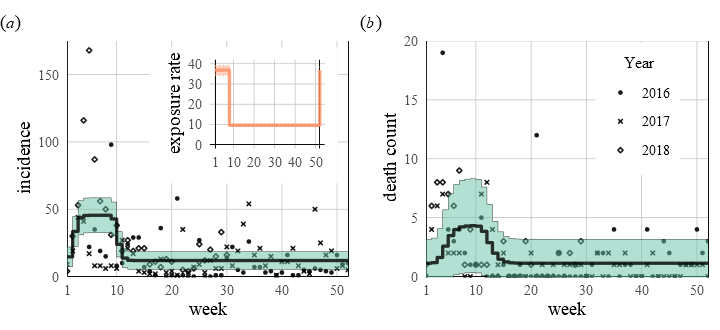

In [110]:
cs = c(6,2.75)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

alpha0 = 0.4
chi2value = 3.841/2

clr = c("#fc8d62","#66c2a5") %>% rev

df_fit2 %>%
    ggplot(aes(x=Week)) +
        geom_hline(yintercept=0,size=.2,color="black") +
        geom_vline(xintercept=1,size=.2,color="black") +
        geom_vline(xintercept=52,size=.2,color="black") +
        # exposure
        geom_step(aes(y=a),alpha=.8,size=.7,color=clr[2]) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=aCILower, ymax=aCIUpper),fill=clr[2],alpha=alpha0) +
        geom_step(aes(y=aCILower),alpha=.8,linetype=3,color=clr[2],size=.25) +
        geom_step(aes(y=aCIUpper),alpha=.8,linetype=3,color=clr[2],size=.25) +
        coord_cartesian(ylim=c(0,ymax)) + expand_limits(x = 1, y = 0) +
        scale_x_continuous(NULL,breaks = c(1,seq(10,52,10))) +
        scale_y_continuous("exposure rate") +
        guides(shape=FALSE,color=FALSE) +
        theme_minimal(base_size=11,base_family='Times') +
        theme(
              panel.grid.major = element_line(colour = "grey",size=.15),
              panel.grid.minor = element_blank(),
              plot.margin = unit(c(.5,.5,.5,.75),"lines")) -> pExposureMLE

dfTrj %>% 
    filter(Year==2017) %>%
    mutate_all(as.numeric) %>%
    mutate(lower=lambda_incidence-chi2value*sqrt(lambda_incidence),
           upper=lambda_incidence+chi2value*sqrt(lambda_incidence)) %>%
    ggplot(aes(x=Week)) +
        geom_hline(yintercept=0,size=.2,color="black") +
        geom_vline(xintercept=1,size=.2,color="black") +
        geom_vline(xintercept=52,size=.2,color="black") +
        # data
        geom_point(data=data %>% filter(Year>=yearMin) %>% mutate(Year = Year%>%as.factor),
                   aes(y=Incidence_Reported,shape=Year),size=.7,alpha=.9) +
        # fit
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=lower, ymax=upper),fill=clr[1],alpha=alphaNarrow) +
        geom_step(aes(y=lower),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=upper),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=lambda_incidence),alpha=.8,size=.7) +
        # layout
        guides(shape=FALSE) +
        scale_shape_manual(values=pchs) +
        expand_limits(x = 1, y = 0) +
        scale_x_continuous(breaks = c(1,seq(10,52,10))) +
        coord_cartesian(ylim=c(0,175),expand=0) +
        labs(x="week",y="incidence") +
        theme_minimal(base_size=11,base_family='Times') +
        theme(
              panel.grid.major = element_line(colour = "grey",size=.15),
              panel.grid.minor = element_blank(),
              plot.margin = unit(c(.5,.5,.5,.75),"lines")) -> pltIncidenceMLE

dfTrj %>% 
    filter(Year==2017) %>%
    mutate_all(as.numeric) %>% 
    mutate(lower=lambda_deaths-chi2value*sqrt(lambda_deaths),
           upper=lambda_deaths+chi2value*sqrt(lambda_deaths)) %>%
    ggplot(aes(x=Week)) +
        geom_hline(yintercept=0,size=.2,color="black") +
        geom_vline(xintercept=1,size=.2,color="black") +
        geom_vline(xintercept=52,size=.2,color="black") +
        # data
        geom_point(data=data %>% filter(Year>=yearMin) %>% mutate(Year = Year%>%as.factor),
                   aes(y=Incidence_Deaths,shape=Year),size=.7,alpha=.9) +
        # fit
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymin=lower, ymax=upper),fill=clr[1],alpha=alphaNarrow) +
        geom_step(aes(y=lower),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=upper),alpha=.8,linetype=1,color="black",size=.1) +
        geom_step(aes(y=lambda_deaths),alpha=.8,size=.7) +
        # layout
        guides(shape=guide_legend(ncol = 1, title = "Year", title.hjust=.55)) +
        scale_shape_manual(values=pchs) +
        expand_limits(x = 1, y = 0) +
        scale_x_continuous(breaks = c(1,seq(10,52,10))) +
        coord_cartesian(ylim=c(0,20),expand=0) +
        labs(x="week",y="death count") +
        theme_minimal(base_size=11,base_family='Times') +
        theme(legend.position = c(0.75, 0.71),
              legend.background = element_rect(colour = "white"),
              legend.text=element_text(size=8),
              legend.title=element_text(size=9),
              panel.grid.major = element_line(colour = "grey",size=.15),
              panel.grid.minor = element_blank(),
              plot.margin = unit(c(.5,.5,.5,1),"lines")) -> pltDeathsMLE


pltIncidenceMLE = pltIncidenceMLE + 
    annotation_custom(grob = ggplotGrob(pExposureMLE+theme(plot.background = element_rect(colour = "white"))), 
                    xmin = 16, xmax = 50, ymin = 70, ymax = 170)

pltIncidenceMLE = arrangeGrob(pltIncidenceMLE, 
                    top = textGrob(expression((italic(a))), 
                    x = unit(0, "npc"), y = unit(.5, "npc"), just=c("left","top"),
                    gp=gpar(col="black", fontsize=9, fontface="italic", fontfamily="Times")))

pltDeathsMLE = arrangeGrob(pltDeathsMLE, 
                    top = textGrob(expression((italic(b))), 
                    x = unit(0, "npc"), y = unit(.5, "npc"), just=c("left","top"),
                    gp=gpar(col="black", fontsize=9, fontface="italic", fontfamily="Times")))

pltFinalMLE = grid.arrange(pltIncidenceMLE, pltDeathsMLE, widths=c(1,1), heights=c(1), nrow=1, ncol=2)

ggsave(plot=pltFinalMLE,width=cs[1],height=cs[2],filename="../figures/AppendixFig6.pdf", useDingbats=FALSE)